# Class Conditional DDIM

## Setup

In [1]:
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import cv2
import pandas as pd
import numpy as np
import datetime
from PIL import Image
    
from tensorflow import keras
from keras import layers
from keras import utils
from glob import glob
import Data_loader2

### tensorflow numba 확인

In [2]:
!echo 0 | sudo tee -a /sys/bus/pci/devices/0000\:00\:04.0/numa_node

/bin/bash: /home/paul025220/anaconda3/envs/itoi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
0


## GPU 확인

In [3]:
import tensorflow as tf

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-12-12 03:53:48.447963: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 03:53:49.306074: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 14640 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12638403496554122309
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15352135680
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2712687396510739480
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
 xla_global_id: 416903419]

## 하이퍼 파라미터

## tfrecord 불러오기

In [5]:
train_dataset = Data_loader2.load_tfrecord_dataset('/home/paul025220/AIFFELTHON/data/train.tfrecord', batch_size=batch_size)
val_dataset = Data_loader2.load_tfrecord_dataset('/home/paul025220/AIFFELTHON/data/val.tfrecord', batch_size=batch_size)

2022-12-12 03:53:49.330962: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14640 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0


## 데이터셋 확인

In [6]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(256, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 8), dtype=tf.float32, name=None))>

In [7]:
val_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(256, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 8), dtype=tf.float32, name=None))>

## KID

* KID : Kernel Inception Distance
* MMD(Maximum Mean Discrepancy)를 feature space에서 진행하는 것을 의미
* 실제 이미지와 가짜 이미지, 가짜 이미지와 실제 이미지 세트간의 similarity를 보는 방법
* 실제 이미지 셋 p, 가짜 이미지셋 q라고 두고
* p에서 2장을 뽑고 두 이미지간의 차이를 구하는 것을 반복해서 이미지들간의 차이가 어떻게 되는지 기댓값을 구합니다.
* q에서도 똑같은 행동을 취합니다.
* 마지막으로 p에서 하나, q에서 하나를 뽑아서 평균적인 차이를 구합니다.

In [8]:
class KID(keras.metrics.Metric):
    def __init__(self, name, **kwargs):
        super().__init__(name=name, **kwargs)

        # KID 배치마다 계산되며 배치간의 값들로 평균을 냅니다.
        self.kid_tracker = keras.metrics.Mean(name="kid_tracker")

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                keras.Input(shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = tf.cast(tf.shape(features_1)[1], dtype=tf.float32)
        return (features_1 @ tf.transpose(features_2) / feature_dimensions + 1.0) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = tf.shape(real_features)[0]
        batch_size_f = tf.cast(batch_size, dtype=tf.float32)
        mean_kernel_real = tf.reduce_sum(kernel_real * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = tf.reduce_sum(
            kernel_generated * (1.0 - tf.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = tf.reduce_mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()


## 네트워크 구조

* U-Net 구조 : Input과 Output이 동일한 형태로
* Downsampling 한 뒤 Upsampling 하는 구조, layer들 간의 skip connectoins은 같은 resolutoin을 가진다.
* 네트워크는 noisy image와 noisy variances 2개의 값을 입력 받습니다.
* Noise variances는 노이즈 제거 과정이 다른 레벨의 노이즈에서 다른 명령(함수)가 필요하기 때문입니다.
* Noise variacnes는 sinusoidal embedding(positional embedding과 비슷한)을 통해 변환됩니다.
* 이 과정은 네트워크가 noise level에 매우 민감하게 만들어주며 이는 좋은 성능과 연결됩니다.
* Lambda layer를 통해 sinusoidal embedding을 구현하였습니다.

### Sinusoidal Embedding

In [9]:
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings

### Residual Block

In [10]:
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply

### Up Down Block

In [11]:
def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply

## Get Network

In [12]:
def get_network(image_size, widths, num_class, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, 3))
    noise_variances = keras.Input(shape=(1, 1, 1))
    class_vector = keras.Input(shape = (num_class,))
    
    e = layers.Lambda(sinusoidal_embedding)(noise_variances)
#     print('e :', e)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)
#     print('e :',e)
    
    i = layers.Dense(class_embedding_dims)(class_vector)
#     print('i :',i)
#     i = layers.Reshape((1,1,class_embedding_dims))(i)
    i = i[:,None,None,:]
#     print('i :',i)
    i = layers.UpSampling2D(size=image_size, interpolation="nearest")(i)
#     print('i :',i)
    
    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, i, e])
#     print('x', x)

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)
#     x = layers.Conv2D(1, kernel_size=1, kernel_initializer="zeros")(x)
    

    return keras.Model([noisy_images, noise_variances, class_vector], x, name="residual_unet")

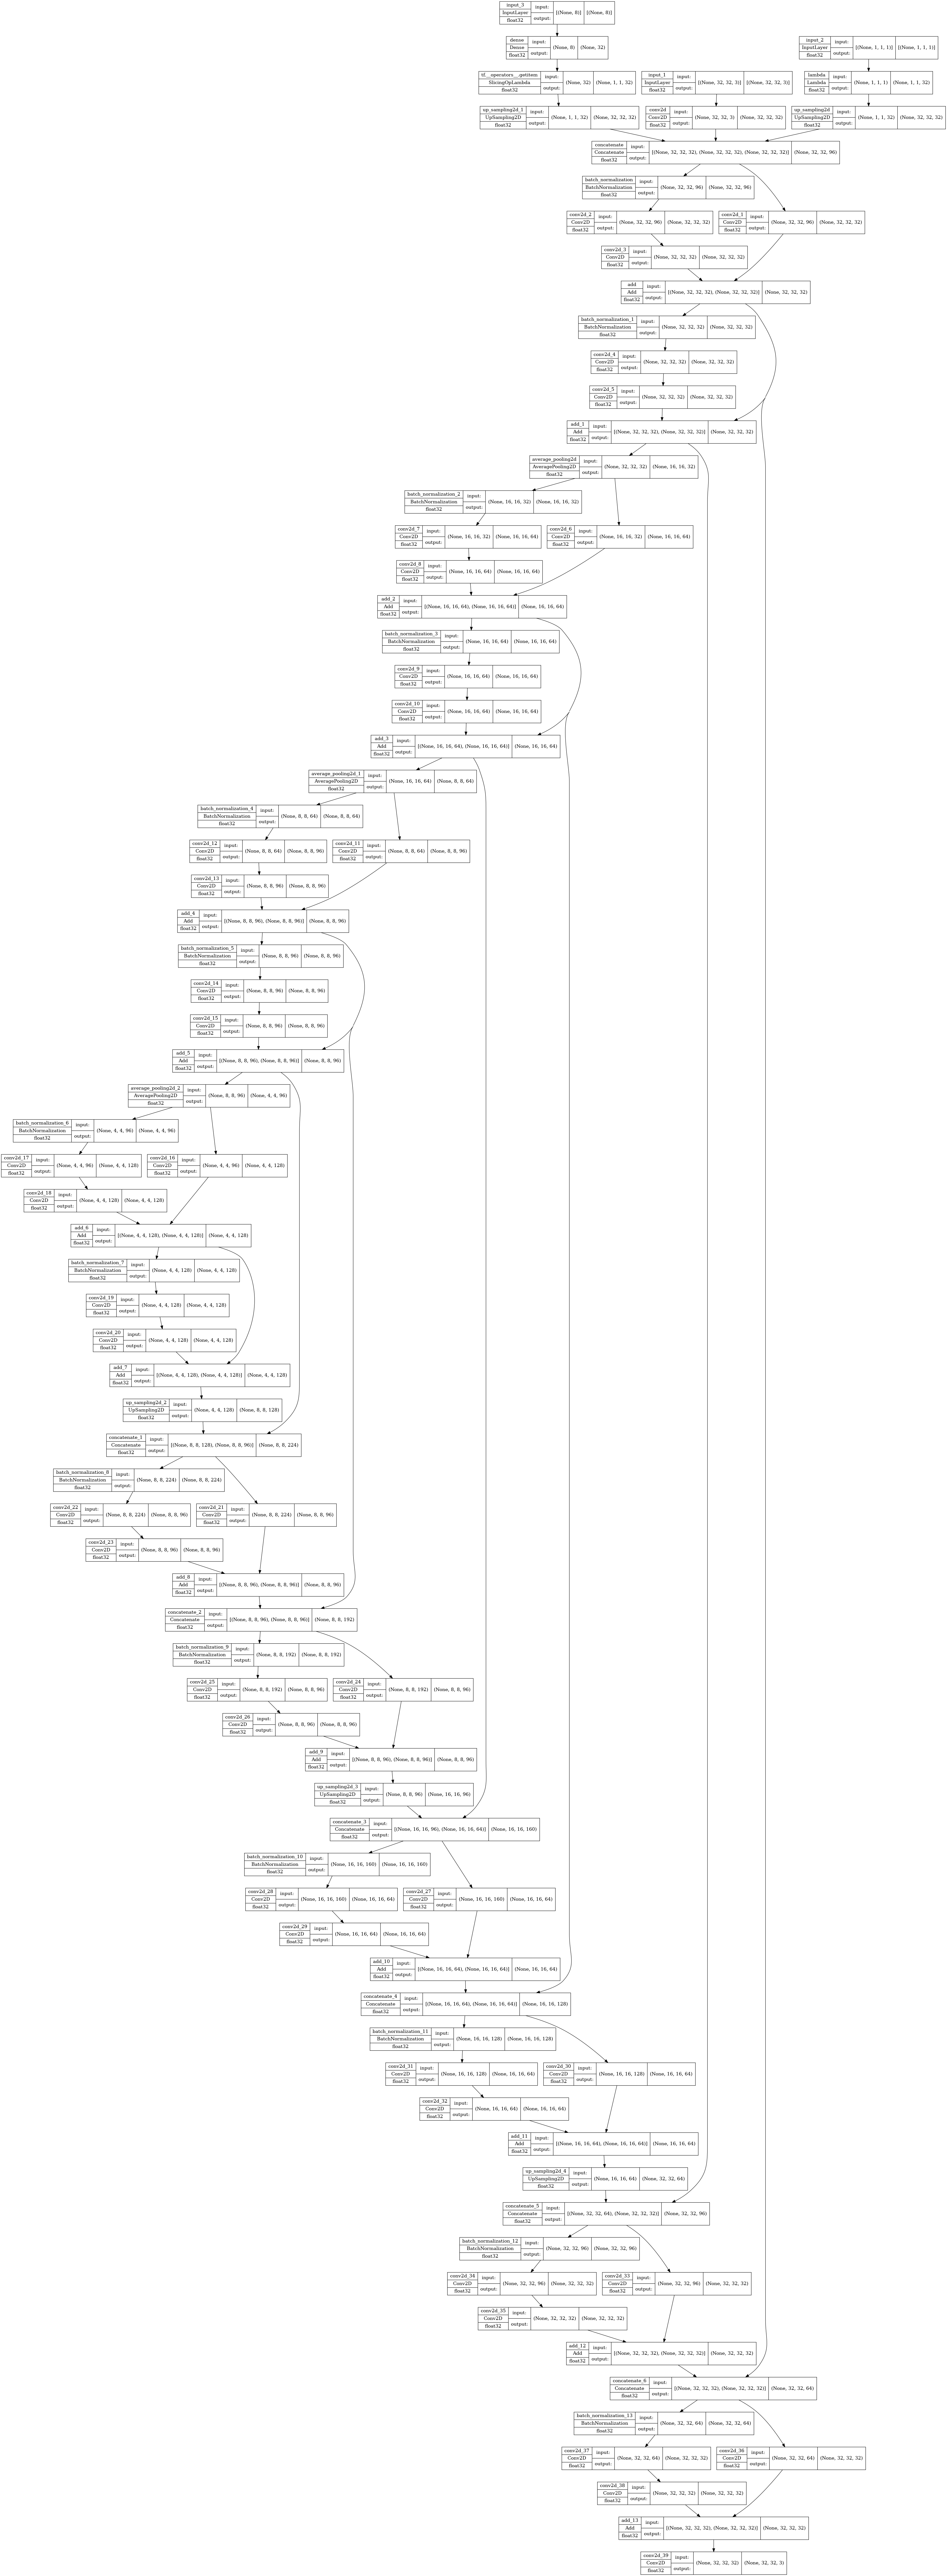

In [13]:
from tensorflow.keras.utils import plot_model

sample_network = get_network(image_size, widths, num_class, block_depth)

plot_model(sample_network, to_file = 'model.png', show_shapes = True, show_dtype = True, show_layer_names = True)


## Diffusion model

### Diffusion Schedule

* Diffusion process의 각 위치에서의 실제 diffusion time에 대응하는 noise level과 signal level를 말해주는 함수가 필요하다.
* 이것이 diffusion schedule 이다.
* Diffusion schedule은 2가지 값을 출력한다.
* noise_rate와 signal_rate(DDPM 논문에서 sqrt(1-alpha)와 sqrt(alpha)에 해당하는)
* 노이즈 이미지는 훈련 이미지에 정해진 비율에 따라 랜덤 노이즈를 부가하고 둘을 합치면서 생성한다.
* 랜덤 노이즈와 이미지가 모두 평균을 0으로 잡고 unit 분산을 가지기 때문에 노이즈 비율과 신호 비율은 노이즈 이미지에서 그들의 표준편차로 볼 수 있다.
* 그들 비율의 제곱은 결국 분산이 된다.
* 비율들은 제곱 합이 1이 되도록 설정되며, 이는 노이즈 이미지가 언제나 unit 분산을 가지는 것을 뜻합니다(변화되지않은 값들 처럼)
* 우린 cosine schedule의 simplifed, continuous 버전을 사용합니다.
* 이 스케쥴은 대칭적이며 Diffusion 시작과 끝을 향해선 느려지며, trigonometric properties of the unit circle을 통한 기하하적 해석을 가집니다.

### Training Process

* train 과정은 train_step과 denoise 이며
* 무작위 diffusion 시간을 균등하게 샘플하며
* 훈련 이미지와 무작위 가우시안 노이즈를 diffusion 시간에 따른 비율에 따라 섞습니다.
* 그리고 노이즈 이미지를 두 가지 요소로 나누기 위해 모델을 훈련합니다.
* 뉴런 네트워크는 변하지 않은 노이즈 요소를 예측하기 위해 학습되며 예측한 이미지 요소는 신호와 노이즈 비율에 따라 계산될 수 있습니다.
* 픽셀 단위의 MSE가 이론적으로 사용되나, 해당 dataset에서는 MAE가 더 좋게 나오니 이것을 사용하겠습니다.

### Sampling

* 샘플링에서는 (reverse diffusion()에서), 각 단계에서 노이즈 이미지의 이전 예측값을 우리의 네트워크를 사용해서 노이즈와 이미지로 나눕니다.
* 해당 단계에서의 신호와 노이즈 비율을 사용하여 다시 재결합합니다.
* Stochastic sampling 네트워크를 재훈련하지 않고도 사용할 수 있다(두 모델 다 같은 방식으로 훈련하기 때문)

In [14]:
class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, num_class, block_depth):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = get_network(image_size, widths, num_class, block_depth)
        self.ema_network = keras.models.clone_model(self.network)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")
        self.kid = KID(name="kid")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker, self.kid]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, class_vector, training):
        # print("denoise start")
        # the exponential moving average weights are used at evaluation
        if training:
            network = self.network
        else:
            network = self.ema_network

        # predict noise component and calculate the image component using it
        # pred_noises = network([noisy_images, noise_rates**2], training=training)
        pred_noises = network([noisy_images, noise_rates**2, class_vector], training=training)
        # print("denoise get noises")
    
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        # print("denoise get images") 
        
        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps, class_vector):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, class_vector, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            # this new noisy image will be used in the next step

        return pred_images

    def generate(self, num_images, diffusion_steps, class_vector):
        # noise -> images -> denormalized images
        initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, 3))
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps, class_vector)
        generated_images = self.denormalize(generated_images)
        return generated_images

    # def train_step(self, images):
    def train_step(self, data):
        # normalize images to have standard deviation of 1, like the noises

        images, label = data
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises
        
        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, label, training=True
            )
            noise_loss = self.loss(noises, pred_noises)  # used for training
            image_loss = self.loss(images, pred_images)  # only used as metric
            
        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)
    
        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics[:-1]}

    # def test_step(self, images):
    def test_step(self, data):

        images, label = data
        
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=False)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        # use the network to separate noisy images to their components
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, label, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(images, pred_images)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        # measure KID between real and generated images
        # this is computationally demanding, kid_diffusion_steps has to be small
        images = self.denormalize(images)
        generated_images = self.generate(
            num_images=batch_size, diffusion_steps=kid_diffusion_steps, class_vector = label
        )
        self.kid.update_state(images, generated_images)

        return {m.name: m.result() for m in self.metrics}

    # plot random generated images for visual evaluation of generation quality
    def plot_images(self, epoch=None, logs=None, num_rows=2, num_cols=4):
    # def plot_images(self, epoch=None, logs=None, num_rows=1, num_cols=5):
        
        indices = [0,1,2,3,4,5,6,7]
        sample_vector = tf.one_hot(indices, num_class)
        generated_images = self.generate(
            num_images=num_rows * num_cols,
            diffusion_steps=plot_diffusion_steps,
            class_vector =  sample_vector 
        )

        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(generated_images[index])
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()
        
    def plot_one_images(self, input_class = 0, epoch=None, logs=None):
        
        index = [input_class]
        sample_vector = tf.one_hot(index, num_class)
            
        generated_images = self.generate(
            num_images=1,
            diffusion_steps = one_plot_diffusion_steps,
            class_vector =  sample_vector 
        )
        
        plt.figure(figsize=(6,6))
        plt.imshow(generated_images[0])
        plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()
    

## 학습

In [15]:
model = DiffusionModel(image_size, widths, num_class, block_depth)
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
    loss=keras.losses.MeanSquaredError()
)

In [16]:
# save the best model based on the validation KID metric
checkpoint_path = "32/checkpoint/diffusion_model"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_kid",
    mode="min",
    save_best_only=True,
)

# calculate mean and variance of training dataset for normalization
# model.normalizer.adapt(train_image)

In [17]:
# model.load_weights(checkpoint_path)

Epoch 1/100


2022-12-12 03:54:01.963692: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-12-12 03:54:02.518035: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-12 03:54:02.518761: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-12 03:54:02.518792: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-12 03:54:02.519455: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-12 03:54:02.519556: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


    562/Unknown - 86s 141ms/step - n_loss: 0.0465 - i_loss: 1.0708

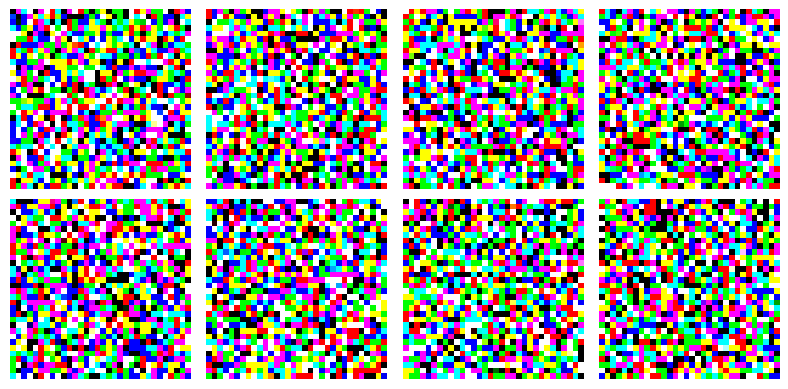

562/562 [==============================] - 106s 177ms/step - n_loss: 0.0465 - i_loss: 1.0708 - val_n_loss: 0.9675 - val_i_loss: 36.4068 - val_kid: 0.7531
Epoch 2/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0159 - i_loss: 0.0617

562/562 [==============================] - 91s 161ms/step - n_loss: 0.0159 - i_loss: 0.0617 - val_n_loss: 0.7495 - val_i_loss: 25.4447 - val_kid: 0.7233
Epoch 3/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0150 - i_loss: 0.0493

562/562 [==============================] - 92s 163ms/step - n_loss: 0.0150 - i_loss: 0.0493 - val_n_loss: 0.4345 - val_i_loss: 13.0415 - val_kid: 0.6801
Epoch 4/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0146 - i_loss: 0.0449

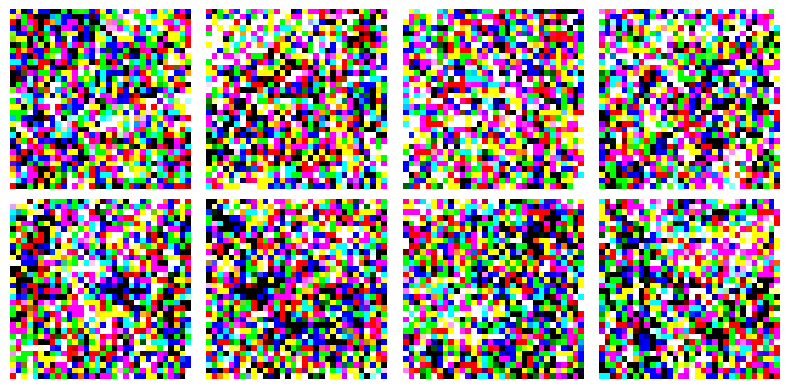

562/562 [==============================] - 91s 162ms/step - n_loss: 0.0146 - i_loss: 0.0449 - val_n_loss: 0.2095 - val_i_loss: 5.2821 - val_kid: 0.6192
Epoch 5/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0143 - i_loss: 0.0424

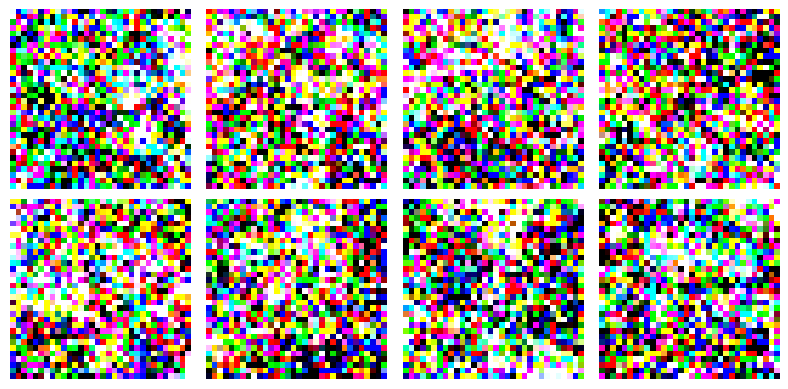

562/562 [==============================] - 91s 162ms/step - n_loss: 0.0143 - i_loss: 0.0424 - val_n_loss: 0.0961 - val_i_loss: 2.3342 - val_kid: 0.5516
Epoch 6/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0142 - i_loss: 0.0409

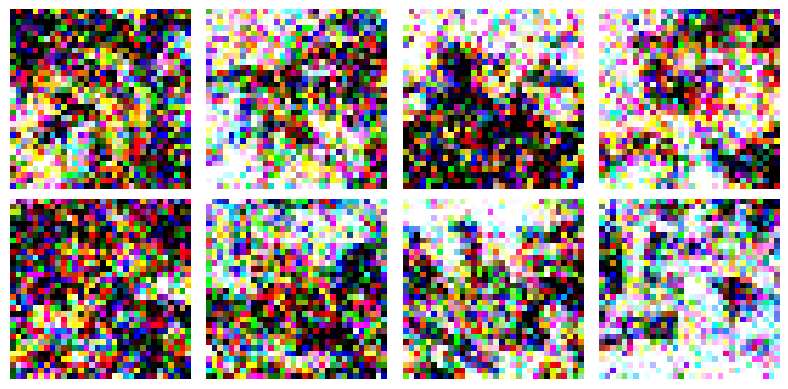

562/562 [==============================] - 91s 162ms/step - n_loss: 0.0142 - i_loss: 0.0409 - val_n_loss: 0.0455 - val_i_loss: 0.9279 - val_kid: 0.4842
Epoch 7/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0141 - i_loss: 0.0391

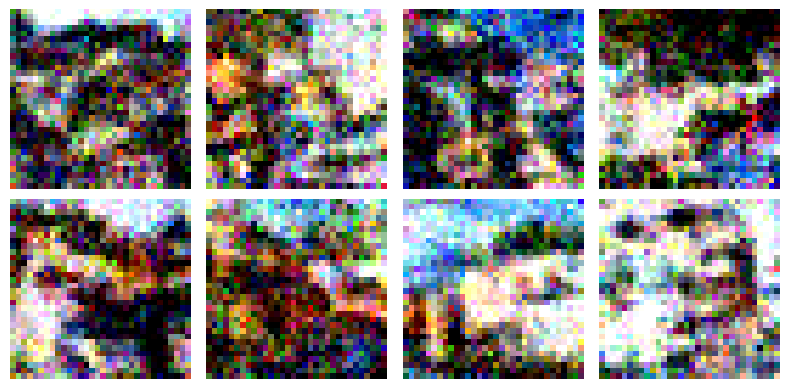

562/562 [==============================] - 90s 161ms/step - n_loss: 0.0141 - i_loss: 0.0391 - val_n_loss: 0.0251 - val_i_loss: 0.3610 - val_kid: 0.4173
Epoch 8/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0140 - i_loss: 0.0385

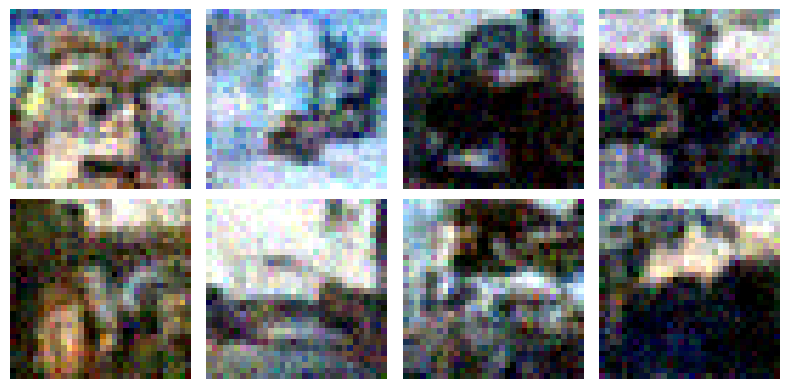

562/562 [==============================] - 90s 160ms/step - n_loss: 0.0140 - i_loss: 0.0385 - val_n_loss: 0.0175 - val_i_loss: 0.1413 - val_kid: 0.2965
Epoch 9/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0138 - i_loss: 0.0342

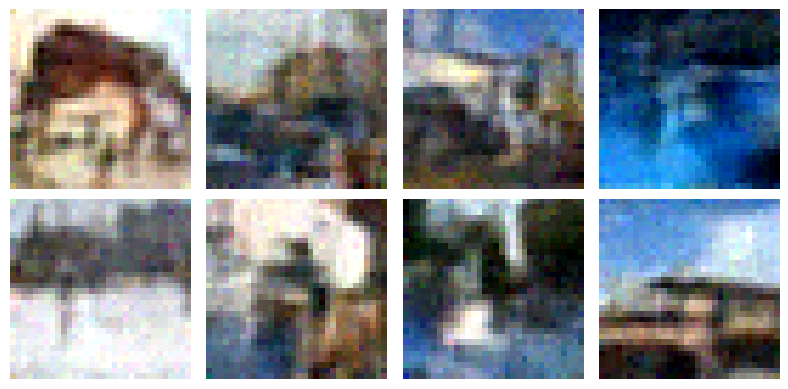

562/562 [==============================] - 90s 161ms/step - n_loss: 0.0138 - i_loss: 0.0342 - val_n_loss: 0.0147 - val_i_loss: 0.0646 - val_kid: 0.1892
Epoch 10/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0138 - i_loss: 0.0356

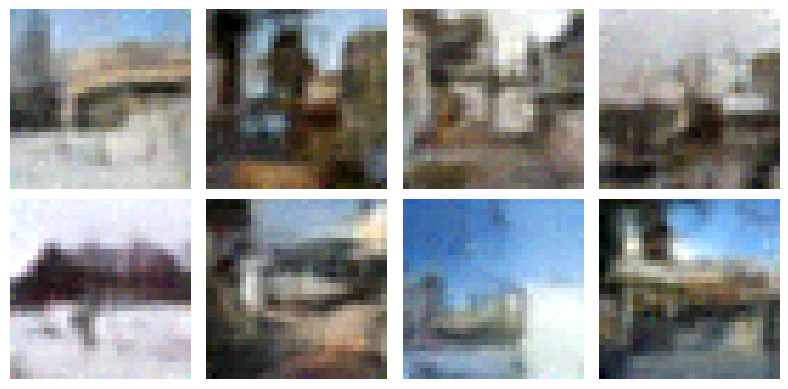

562/562 [==============================] - 90s 160ms/step - n_loss: 0.0138 - i_loss: 0.0356 - val_n_loss: 0.0136 - val_i_loss: 0.0370 - val_kid: 0.1471
Epoch 11/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0137 - i_loss: 0.0337

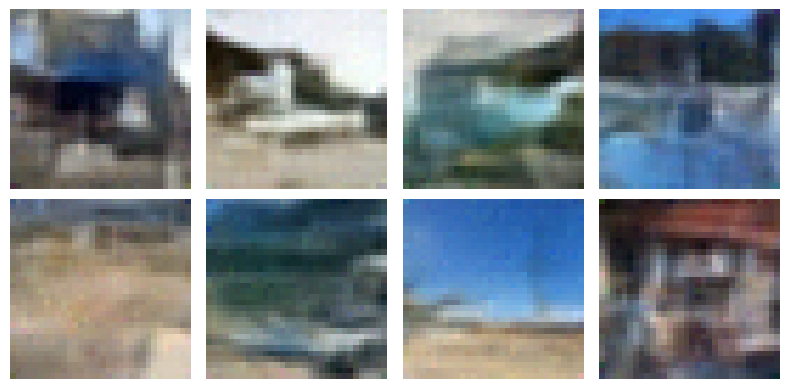

562/562 [==============================] - 90s 159ms/step - n_loss: 0.0137 - i_loss: 0.0337 - val_n_loss: 0.0135 - val_i_loss: 0.0287 - val_kid: 0.1304
Epoch 12/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0136 - i_loss: 0.0324

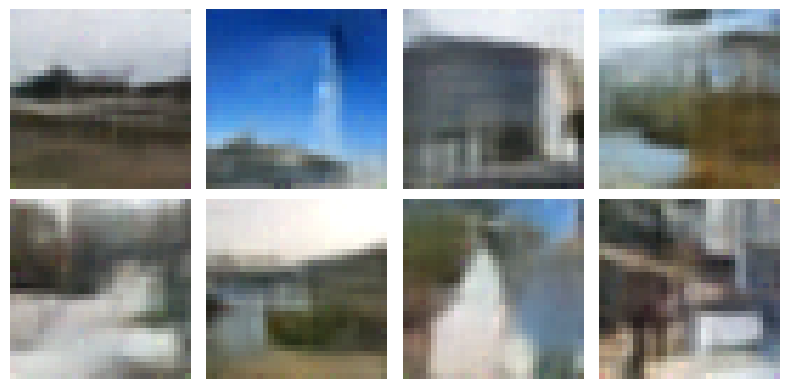

562/562 [==============================] - 90s 159ms/step - n_loss: 0.0136 - i_loss: 0.0324 - val_n_loss: 0.0131 - val_i_loss: 0.0259 - val_kid: 0.1272
Epoch 13/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0136 - i_loss: 0.0320

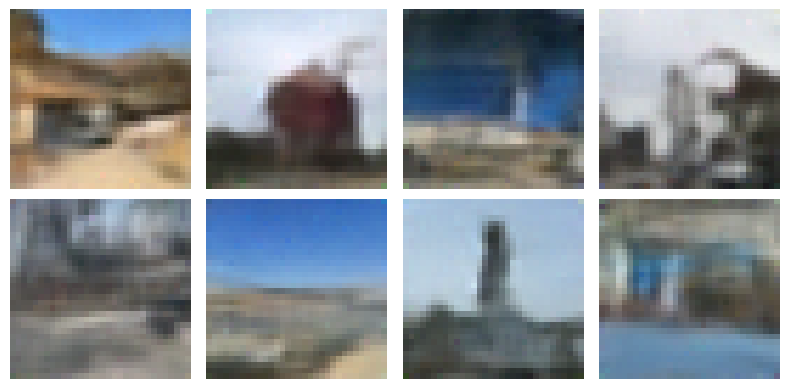

562/562 [==============================] - 89s 159ms/step - n_loss: 0.0136 - i_loss: 0.0320 - val_n_loss: 0.0133 - val_i_loss: 0.0244 - val_kid: 0.1261
Epoch 14/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0136 - i_loss: 0.0315

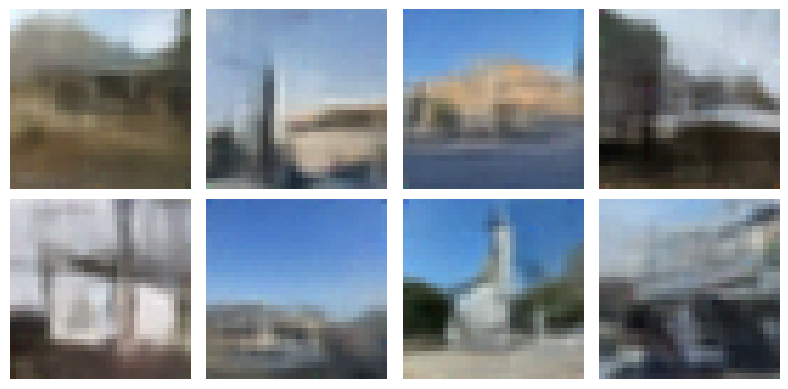

562/562 [==============================] - 89s 158ms/step - n_loss: 0.0136 - i_loss: 0.0315 - val_n_loss: 0.0131 - val_i_loss: 0.0236 - val_kid: 0.1248
Epoch 15/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0135 - i_loss: 0.0311

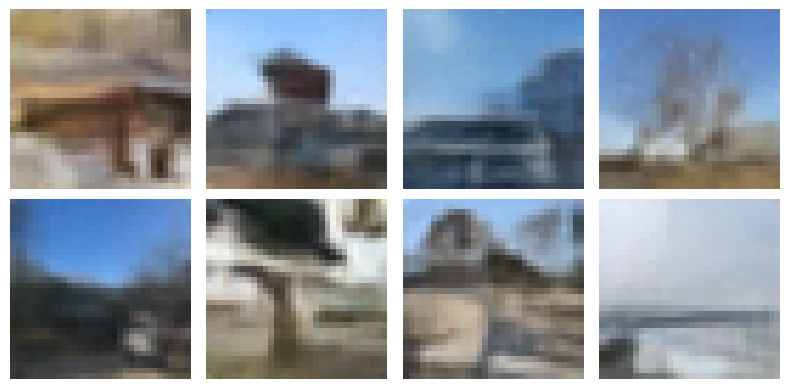

562/562 [==============================] - 88s 156ms/step - n_loss: 0.0135 - i_loss: 0.0311 - val_n_loss: 0.0130 - val_i_loss: 0.0233 - val_kid: 0.1273
Epoch 16/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0135 - i_loss: 0.0300

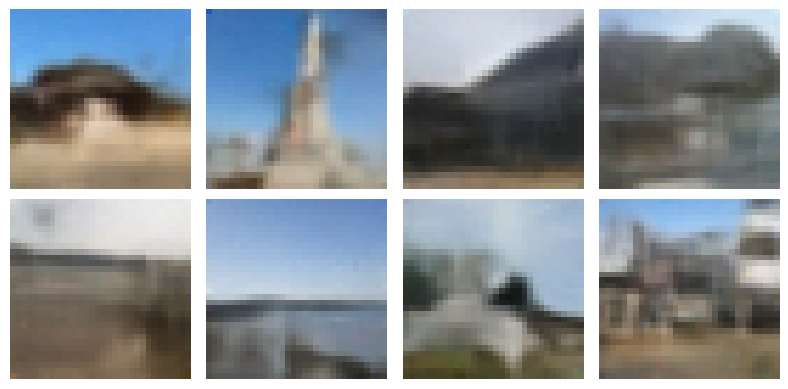

562/562 [==============================] - 88s 156ms/step - n_loss: 0.0135 - i_loss: 0.0300 - val_n_loss: 0.0131 - val_i_loss: 0.0231 - val_kid: 0.1274
Epoch 17/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0135 - i_loss: 0.0305

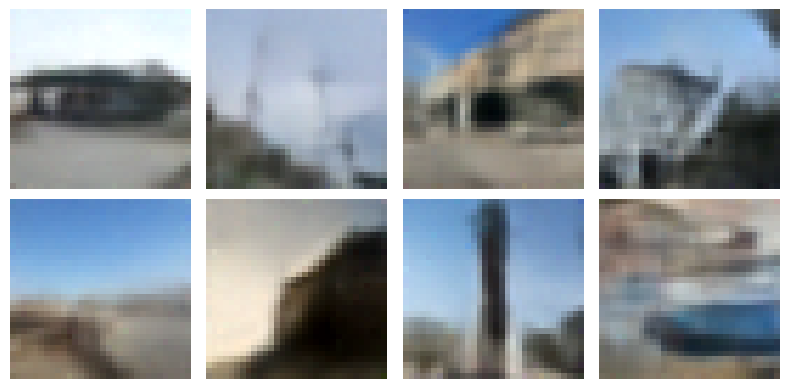

562/562 [==============================] - 87s 155ms/step - n_loss: 0.0135 - i_loss: 0.0305 - val_n_loss: 0.0128 - val_i_loss: 0.0232 - val_kid: 0.1259
Epoch 18/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0134 - i_loss: 0.0292

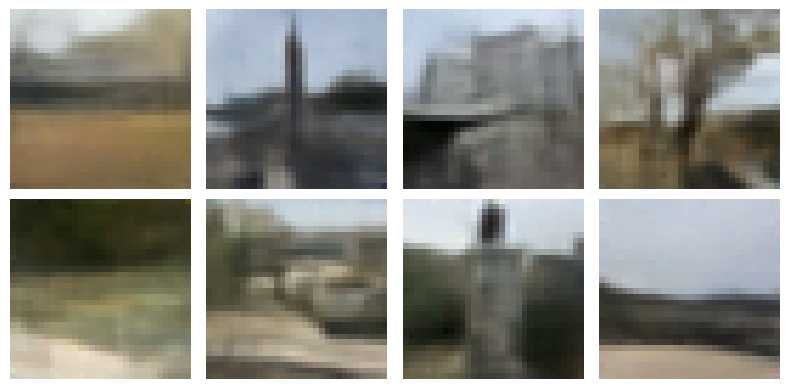

562/562 [==============================] - 87s 155ms/step - n_loss: 0.0134 - i_loss: 0.0292 - val_n_loss: 0.0128 - val_i_loss: 0.0226 - val_kid: 0.1268
Epoch 19/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0134 - i_loss: 0.0299

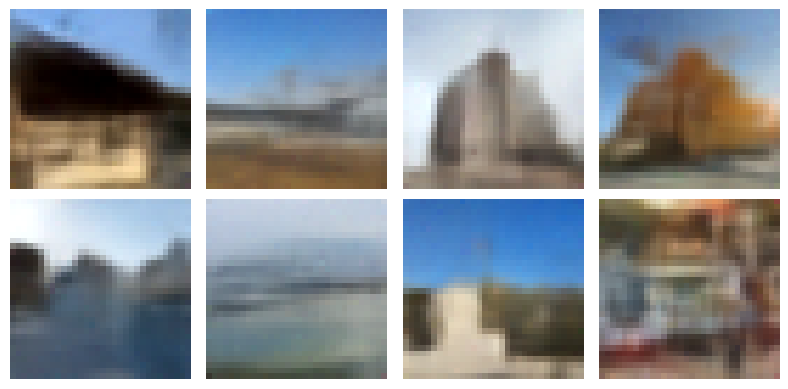

562/562 [==============================] - 87s 155ms/step - n_loss: 0.0134 - i_loss: 0.0299 - val_n_loss: 0.0129 - val_i_loss: 0.0225 - val_kid: 0.1251
Epoch 20/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0133 - i_loss: 0.0288

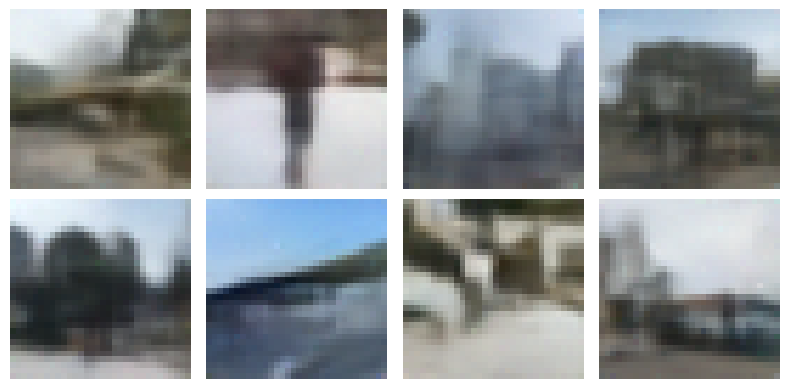

562/562 [==============================] - 87s 155ms/step - n_loss: 0.0133 - i_loss: 0.0288 - val_n_loss: 0.0129 - val_i_loss: 0.0219 - val_kid: 0.1258
Epoch 21/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0132 - i_loss: 0.0282

562/562 [==============================] - 87s 155ms/step - n_loss: 0.0132 - i_loss: 0.0282 - val_n_loss: 0.0129 - val_i_loss: 0.0218 - val_kid: 0.1261
Epoch 22/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0132 - i_loss: 0.0281

562/562 [==============================] - 89s 158ms/step - n_loss: 0.0132 - i_loss: 0.0281 - val_n_loss: 0.0127 - val_i_loss: 0.0218 - val_kid: 0.1236
Epoch 23/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0131 - i_loss: 0.0277

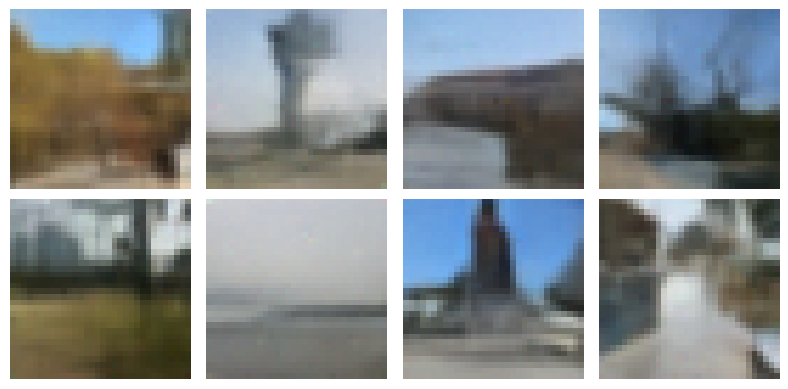

562/562 [==============================] - 88s 157ms/step - n_loss: 0.0131 - i_loss: 0.0277 - val_n_loss: 0.0126 - val_i_loss: 0.0216 - val_kid: 0.1228
Epoch 24/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0131 - i_loss: 0.0276

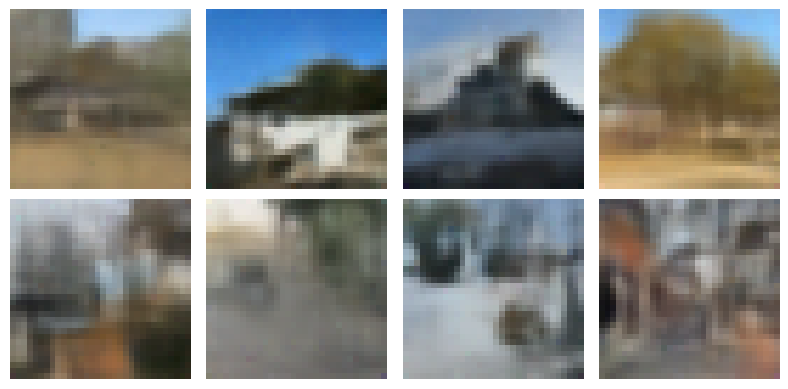

562/562 [==============================] - 88s 157ms/step - n_loss: 0.0131 - i_loss: 0.0276 - val_n_loss: 0.0126 - val_i_loss: 0.0214 - val_kid: 0.1220
Epoch 25/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0132 - i_loss: 0.0278

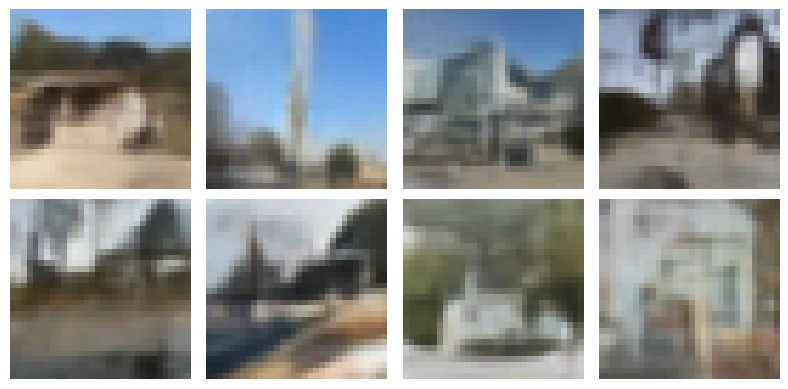

562/562 [==============================] - 87s 155ms/step - n_loss: 0.0132 - i_loss: 0.0278 - val_n_loss: 0.0128 - val_i_loss: 0.0211 - val_kid: 0.1226
Epoch 26/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0131 - i_loss: 0.0268

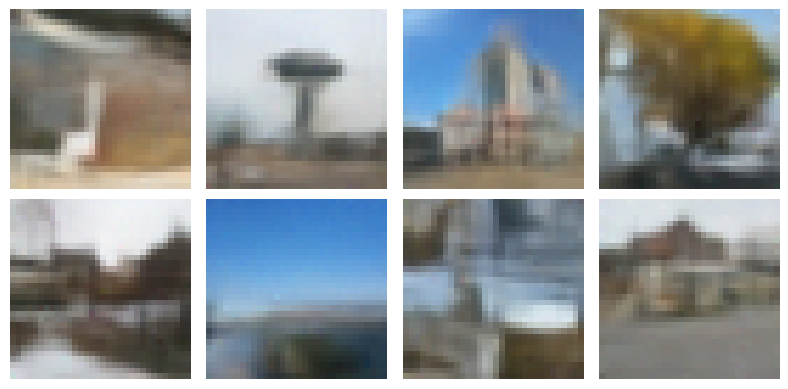

562/562 [==============================] - 87s 155ms/step - n_loss: 0.0131 - i_loss: 0.0268 - val_n_loss: 0.0126 - val_i_loss: 0.0212 - val_kid: 0.1227
Epoch 27/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0131 - i_loss: 0.0267

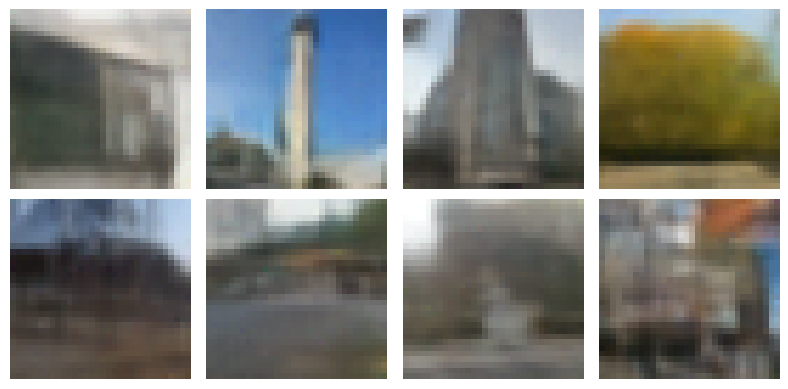

562/562 [==============================] - 87s 154ms/step - n_loss: 0.0131 - i_loss: 0.0267 - val_n_loss: 0.0127 - val_i_loss: 0.0208 - val_kid: 0.1224
Epoch 28/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0130 - i_loss: 0.0272

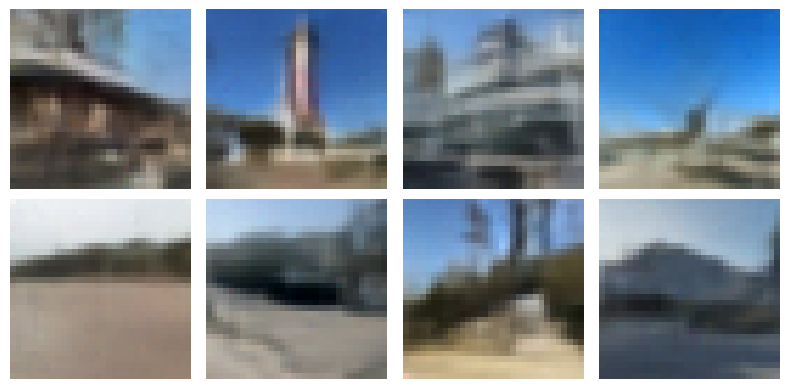

562/562 [==============================] - 87s 154ms/step - n_loss: 0.0130 - i_loss: 0.0272 - val_n_loss: 0.0127 - val_i_loss: 0.0208 - val_kid: 0.1238
Epoch 29/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0130 - i_loss: 0.0268

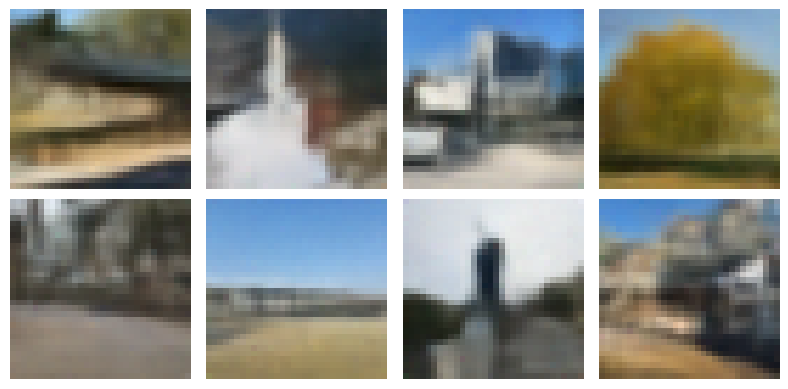

562/562 [==============================] - 87s 154ms/step - n_loss: 0.0130 - i_loss: 0.0268 - val_n_loss: 0.0126 - val_i_loss: 0.0209 - val_kid: 0.1230
Epoch 30/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0130 - i_loss: 0.0265

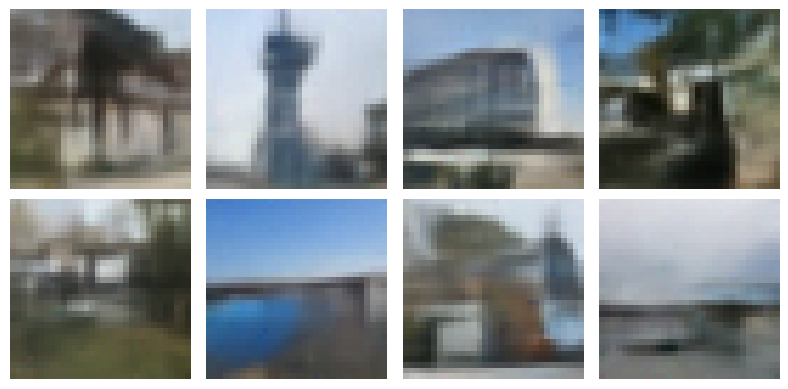

562/562 [==============================] - 88s 156ms/step - n_loss: 0.0130 - i_loss: 0.0265 - val_n_loss: 0.0127 - val_i_loss: 0.0208 - val_kid: 0.1213
Epoch 31/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0130 - i_loss: 0.0266

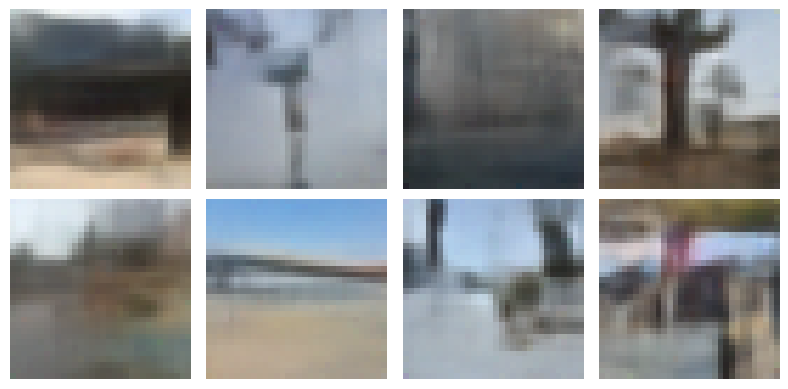

562/562 [==============================] - 87s 154ms/step - n_loss: 0.0130 - i_loss: 0.0266 - val_n_loss: 0.0126 - val_i_loss: 0.0206 - val_kid: 0.1219
Epoch 32/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0130 - i_loss: 0.0260

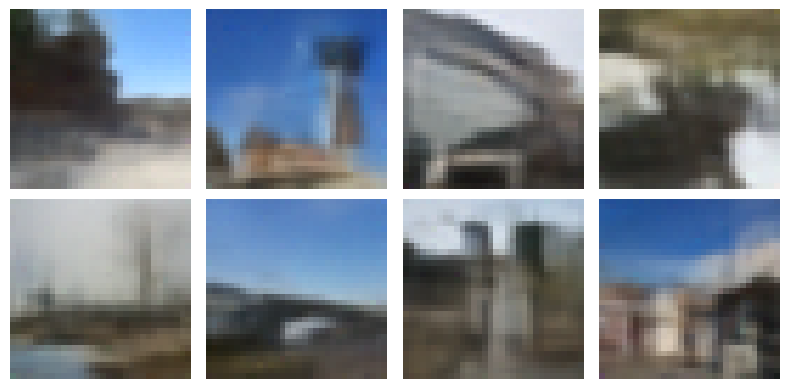

562/562 [==============================] - 87s 154ms/step - n_loss: 0.0130 - i_loss: 0.0260 - val_n_loss: 0.0126 - val_i_loss: 0.0207 - val_kid: 0.1214
Epoch 33/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0130 - i_loss: 0.0266

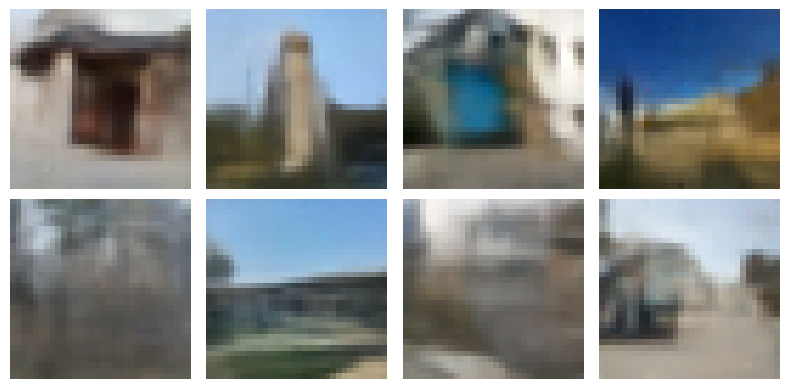

562/562 [==============================] - 87s 154ms/step - n_loss: 0.0130 - i_loss: 0.0266 - val_n_loss: 0.0126 - val_i_loss: 0.0205 - val_kid: 0.1236
Epoch 34/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0130 - i_loss: 0.0264

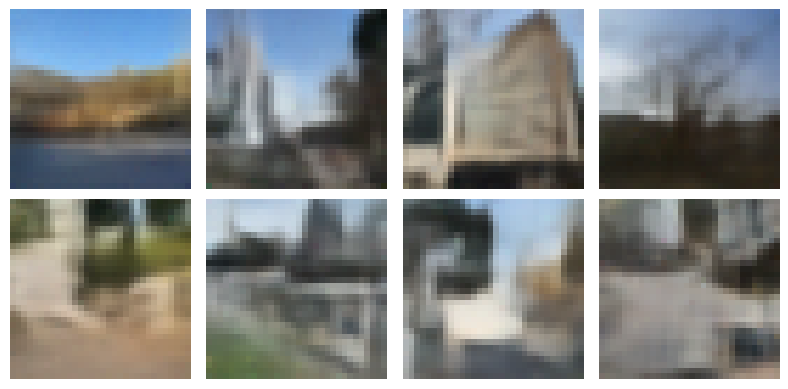

562/562 [==============================] - 87s 154ms/step - n_loss: 0.0130 - i_loss: 0.0264 - val_n_loss: 0.0125 - val_i_loss: 0.0206 - val_kid: 0.1233
Epoch 35/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0129 - i_loss: 0.0262

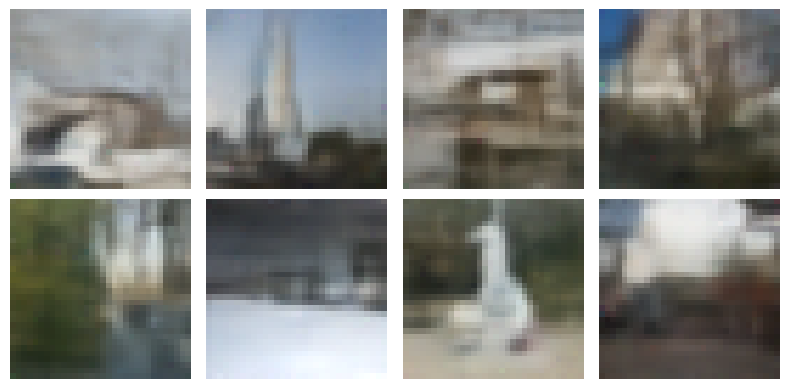

562/562 [==============================] - 87s 154ms/step - n_loss: 0.0129 - i_loss: 0.0262 - val_n_loss: 0.0127 - val_i_loss: 0.0205 - val_kid: 0.1220
Epoch 36/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0129 - i_loss: 0.0264

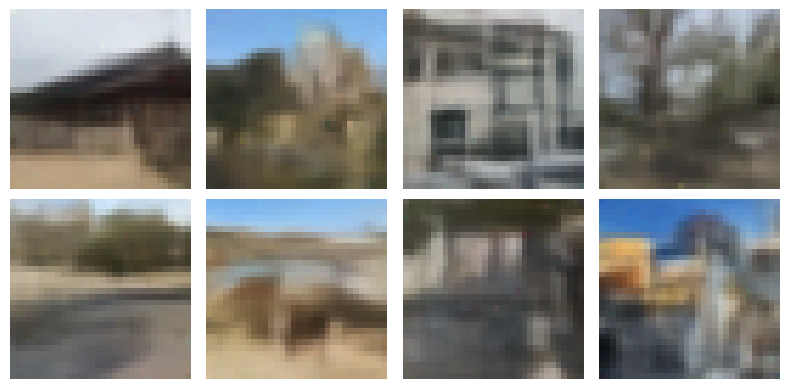

562/562 [==============================] - 87s 154ms/step - n_loss: 0.0129 - i_loss: 0.0264 - val_n_loss: 0.0126 - val_i_loss: 0.0203 - val_kid: 0.1228
Epoch 37/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0129 - i_loss: 0.0260

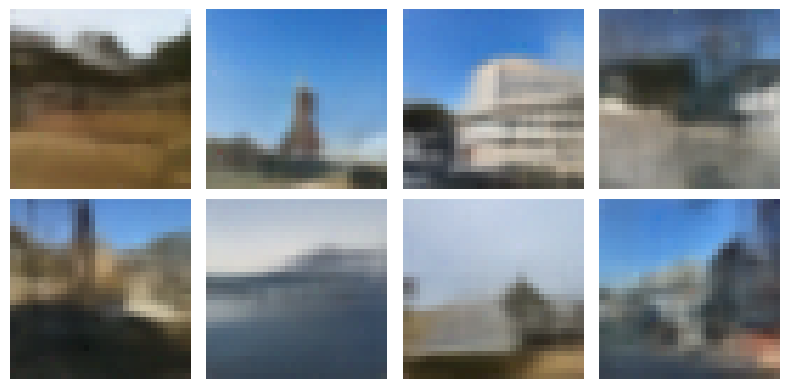

562/562 [==============================] - 87s 155ms/step - n_loss: 0.0129 - i_loss: 0.0260 - val_n_loss: 0.0124 - val_i_loss: 0.0205 - val_kid: 0.1225
Epoch 38/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0129 - i_loss: 0.0259

562/562 [==============================] - 87s 154ms/step - n_loss: 0.0129 - i_loss: 0.0259 - val_n_loss: 0.0124 - val_i_loss: 0.0203 - val_kid: 0.1223
Epoch 39/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0129 - i_loss: 0.0258

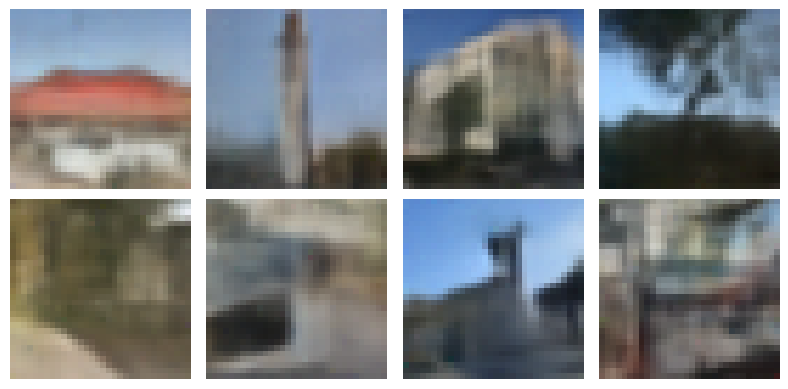

562/562 [==============================] - 87s 154ms/step - n_loss: 0.0129 - i_loss: 0.0258 - val_n_loss: 0.0124 - val_i_loss: 0.0204 - val_kid: 0.1232
Epoch 40/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0128 - i_loss: 0.0265

562/562 [==============================] - 87s 155ms/step - n_loss: 0.0128 - i_loss: 0.0265 - val_n_loss: 0.0126 - val_i_loss: 0.0201 - val_kid: 0.1222
Epoch 41/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0128 - i_loss: 0.0258

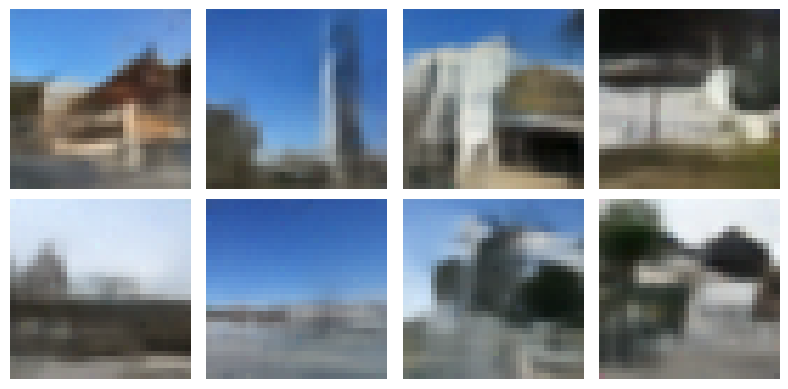

562/562 [==============================] - 87s 154ms/step - n_loss: 0.0128 - i_loss: 0.0258 - val_n_loss: 0.0124 - val_i_loss: 0.0201 - val_kid: 0.1228
Epoch 42/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0128 - i_loss: 0.0260

562/562 [==============================] - 86s 154ms/step - n_loss: 0.0128 - i_loss: 0.0260 - val_n_loss: 0.0124 - val_i_loss: 0.0201 - val_kid: 0.1219
Epoch 43/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0127 - i_loss: 0.0257

562/562 [==============================] - 86s 154ms/step - n_loss: 0.0127 - i_loss: 0.0257 - val_n_loss: 0.0125 - val_i_loss: 0.0200 - val_kid: 0.1220
Epoch 44/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0128 - i_loss: 0.0253

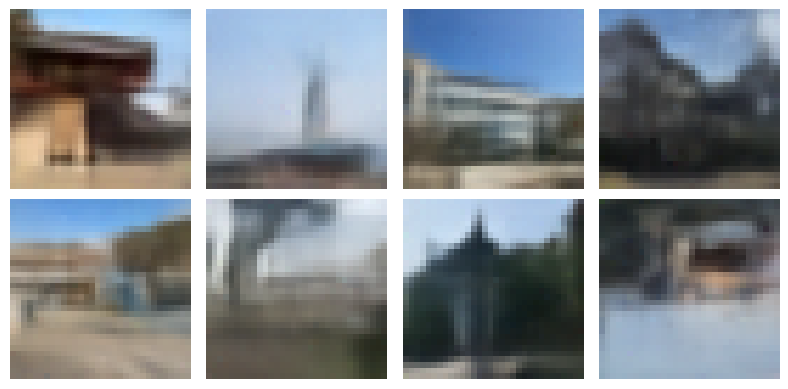

562/562 [==============================] - 87s 154ms/step - n_loss: 0.0128 - i_loss: 0.0253 - val_n_loss: 0.0124 - val_i_loss: 0.0201 - val_kid: 0.1227
Epoch 45/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0127 - i_loss: 0.0263

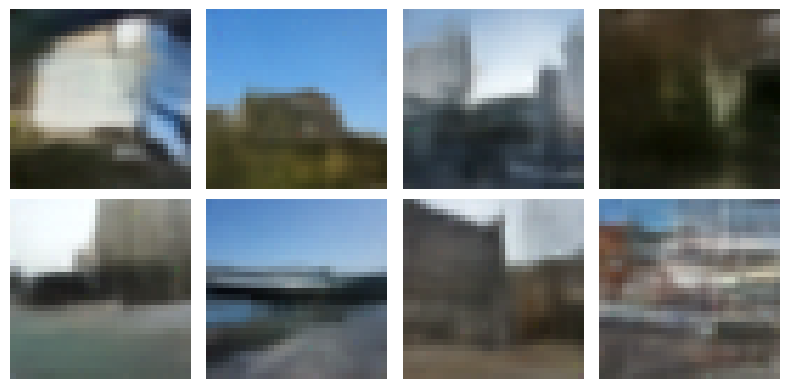

562/562 [==============================] - 87s 155ms/step - n_loss: 0.0127 - i_loss: 0.0263 - val_n_loss: 0.0126 - val_i_loss: 0.0199 - val_kid: 0.1224
Epoch 46/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0127 - i_loss: 0.0260

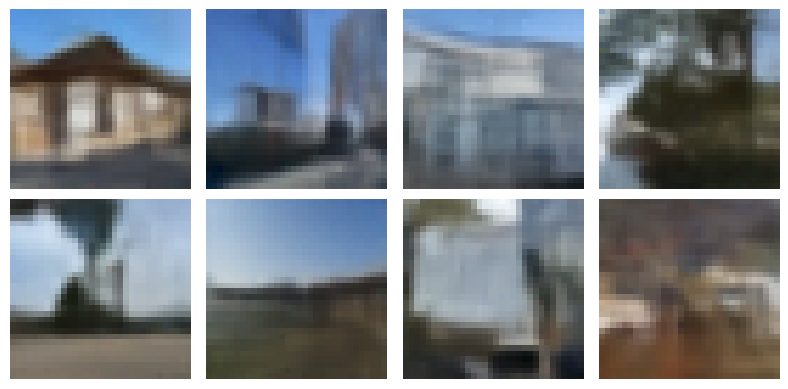

562/562 [==============================] - 86s 154ms/step - n_loss: 0.0127 - i_loss: 0.0260 - val_n_loss: 0.0125 - val_i_loss: 0.0201 - val_kid: 0.1219
Epoch 47/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0127 - i_loss: 0.0255

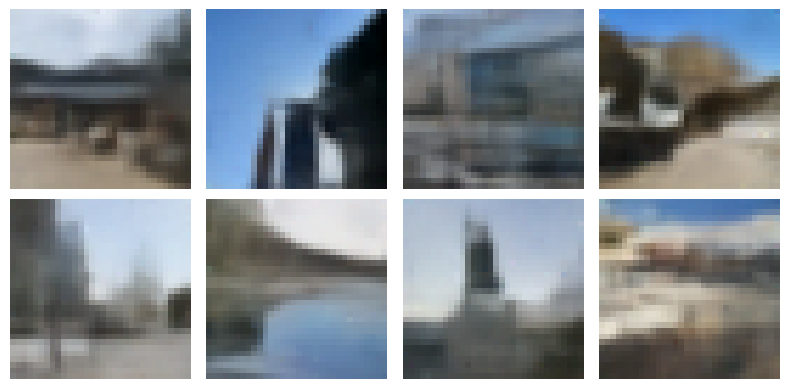

562/562 [==============================] - 88s 156ms/step - n_loss: 0.0127 - i_loss: 0.0255 - val_n_loss: 0.0123 - val_i_loss: 0.0203 - val_kid: 0.1193
Epoch 48/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0128 - i_loss: 0.0255

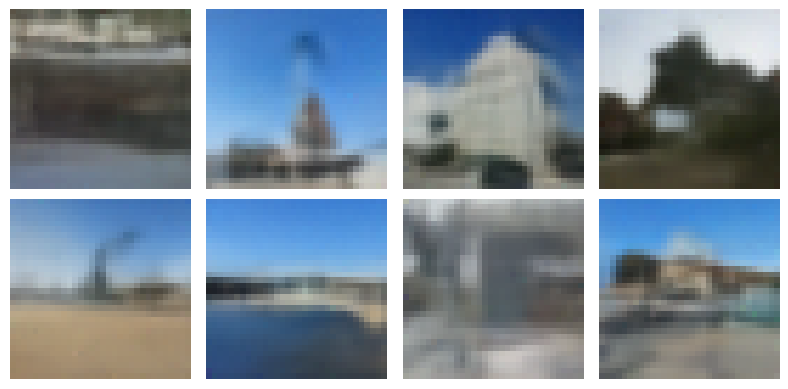

562/562 [==============================] - 86s 153ms/step - n_loss: 0.0128 - i_loss: 0.0255 - val_n_loss: 0.0124 - val_i_loss: 0.0199 - val_kid: 0.1222
Epoch 49/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0127 - i_loss: 0.0252

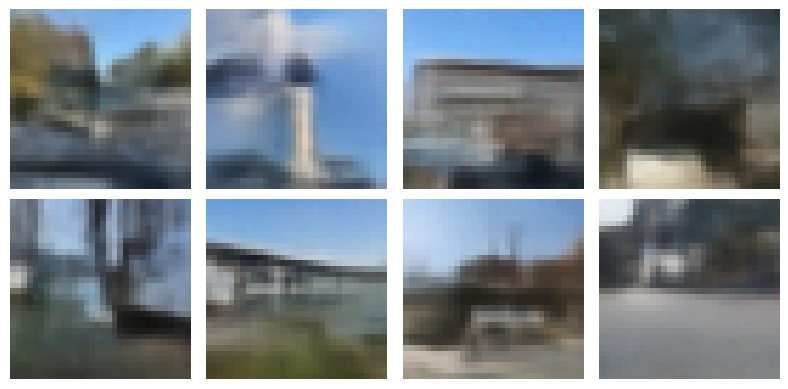

562/562 [==============================] - 86s 154ms/step - n_loss: 0.0127 - i_loss: 0.0252 - val_n_loss: 0.0125 - val_i_loss: 0.0200 - val_kid: 0.1202
Epoch 50/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0127 - i_loss: 0.0259

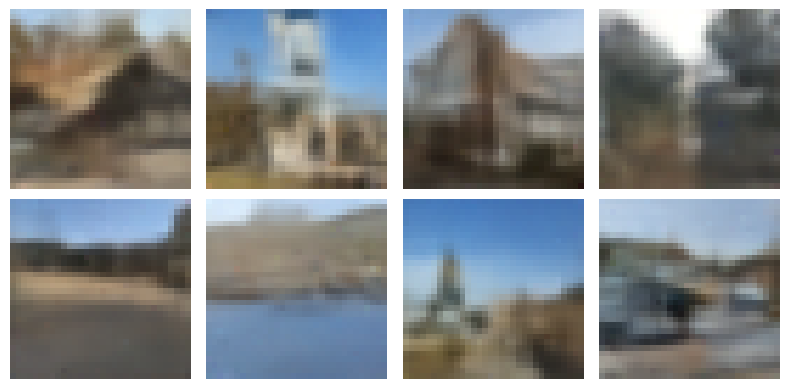

562/562 [==============================] - 87s 154ms/step - n_loss: 0.0127 - i_loss: 0.0259 - val_n_loss: 0.0124 - val_i_loss: 0.0200 - val_kid: 0.1226
Epoch 51/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0127 - i_loss: 0.0259

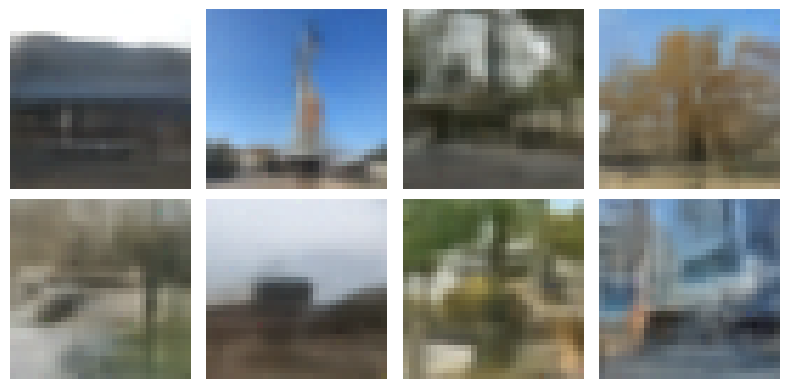

562/562 [==============================] - 86s 153ms/step - n_loss: 0.0127 - i_loss: 0.0259 - val_n_loss: 0.0124 - val_i_loss: 0.0201 - val_kid: 0.1229
Epoch 52/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0127 - i_loss: 0.0252

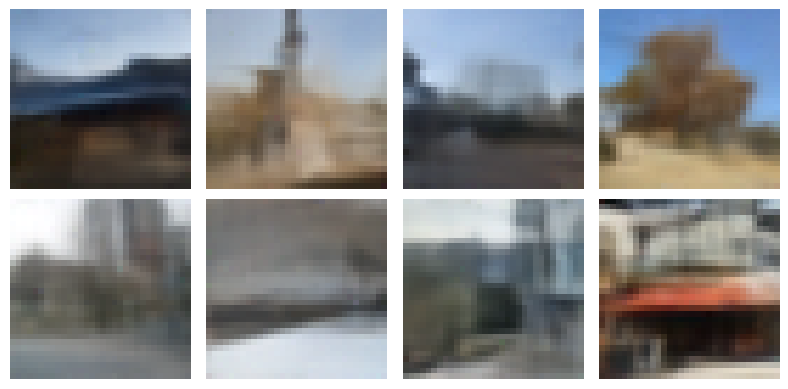

562/562 [==============================] - 87s 155ms/step - n_loss: 0.0127 - i_loss: 0.0252 - val_n_loss: 0.0125 - val_i_loss: 0.0197 - val_kid: 0.1191
Epoch 53/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0126 - i_loss: 0.0259

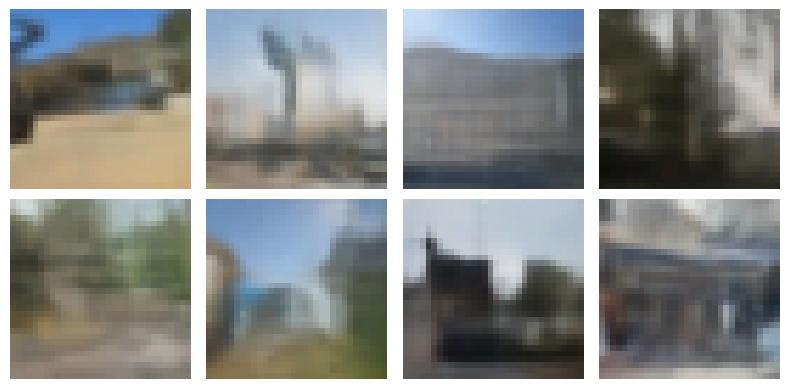

562/562 [==============================] - 86s 153ms/step - n_loss: 0.0126 - i_loss: 0.0259 - val_n_loss: 0.0124 - val_i_loss: 0.0200 - val_kid: 0.1203
Epoch 54/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0127 - i_loss: 0.0256

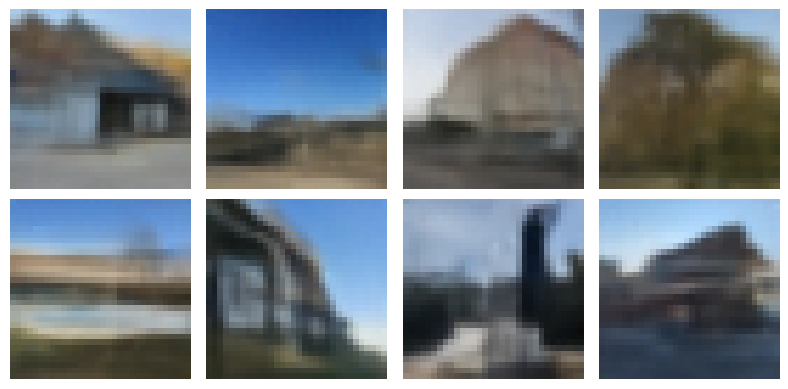

562/562 [==============================] - 87s 154ms/step - n_loss: 0.0127 - i_loss: 0.0256 - val_n_loss: 0.0123 - val_i_loss: 0.0200 - val_kid: 0.1210
Epoch 55/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0126 - i_loss: 0.0260

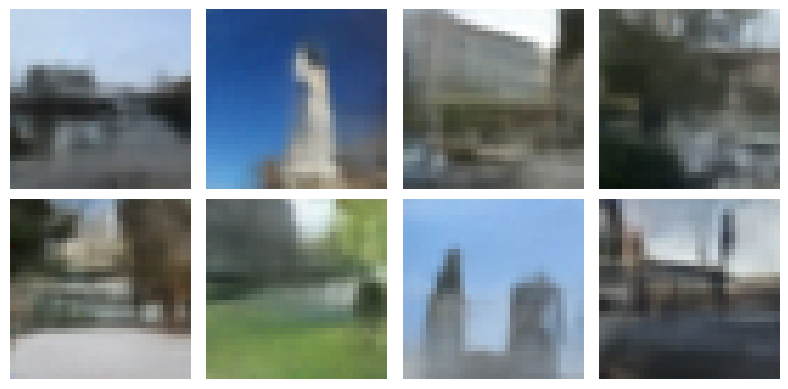

562/562 [==============================] - 86s 153ms/step - n_loss: 0.0126 - i_loss: 0.0260 - val_n_loss: 0.0123 - val_i_loss: 0.0199 - val_kid: 0.1207
Epoch 56/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0126 - i_loss: 0.0260

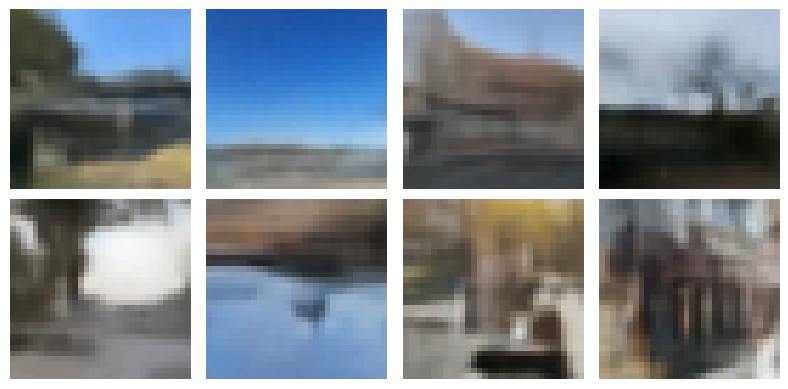

562/562 [==============================] - 87s 155ms/step - n_loss: 0.0126 - i_loss: 0.0260 - val_n_loss: 0.0122 - val_i_loss: 0.0199 - val_kid: 0.1180
Epoch 57/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0126 - i_loss: 0.0259

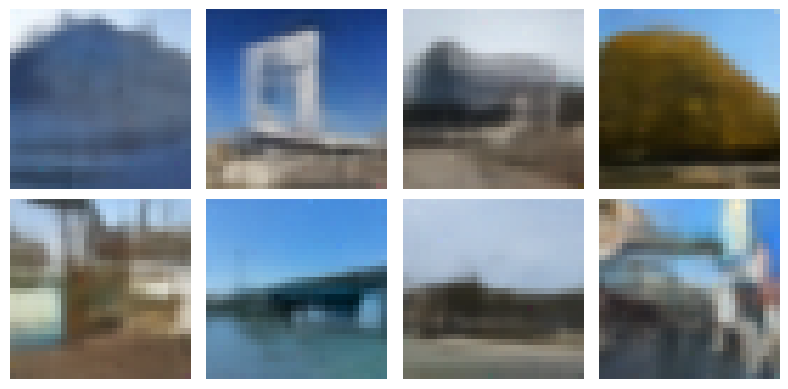

562/562 [==============================] - 87s 155ms/step - n_loss: 0.0126 - i_loss: 0.0259 - val_n_loss: 0.0126 - val_i_loss: 0.0196 - val_kid: 0.1171
Epoch 58/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0126 - i_loss: 0.0256

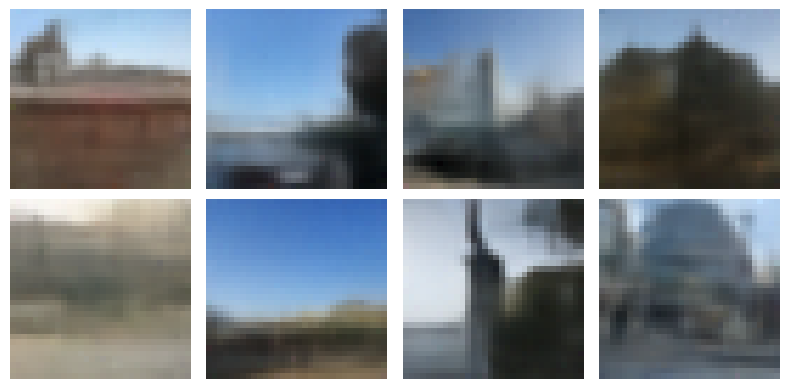

562/562 [==============================] - 86s 153ms/step - n_loss: 0.0126 - i_loss: 0.0256 - val_n_loss: 0.0125 - val_i_loss: 0.0196 - val_kid: 0.1187
Epoch 59/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0126 - i_loss: 0.0252

562/562 [==============================] - 86s 153ms/step - n_loss: 0.0126 - i_loss: 0.0252 - val_n_loss: 0.0123 - val_i_loss: 0.0198 - val_kid: 0.1171
Epoch 60/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0125 - i_loss: 0.0263

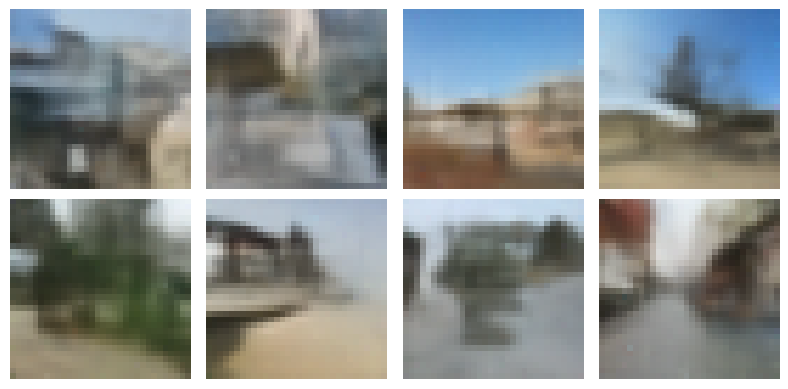

562/562 [==============================] - 87s 155ms/step - n_loss: 0.0125 - i_loss: 0.0263 - val_n_loss: 0.0121 - val_i_loss: 0.0200 - val_kid: 0.1148
Epoch 61/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0126 - i_loss: 0.0256

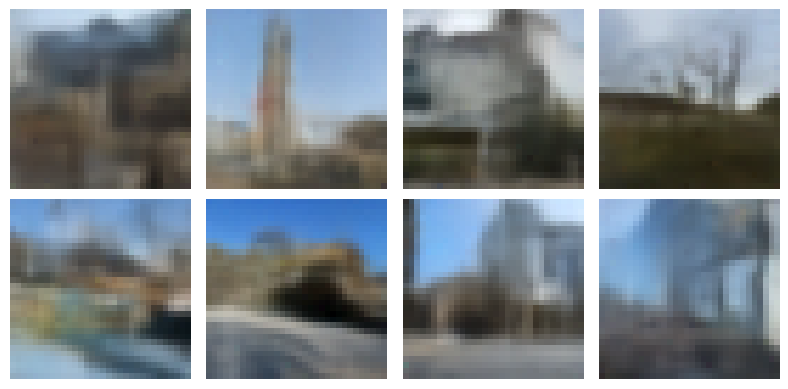

562/562 [==============================] - 86s 154ms/step - n_loss: 0.0126 - i_loss: 0.0256 - val_n_loss: 0.0123 - val_i_loss: 0.0197 - val_kid: 0.1151
Epoch 62/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0126 - i_loss: 0.0253

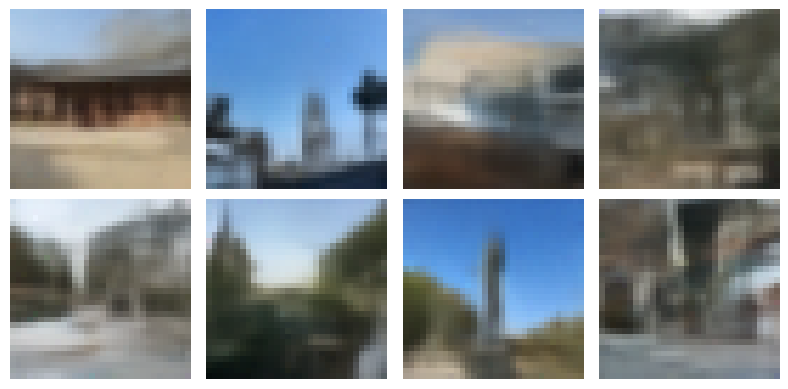

562/562 [==============================] - 87s 154ms/step - n_loss: 0.0126 - i_loss: 0.0253 - val_n_loss: 0.0123 - val_i_loss: 0.0198 - val_kid: 0.1142
Epoch 63/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0126 - i_loss: 0.0251

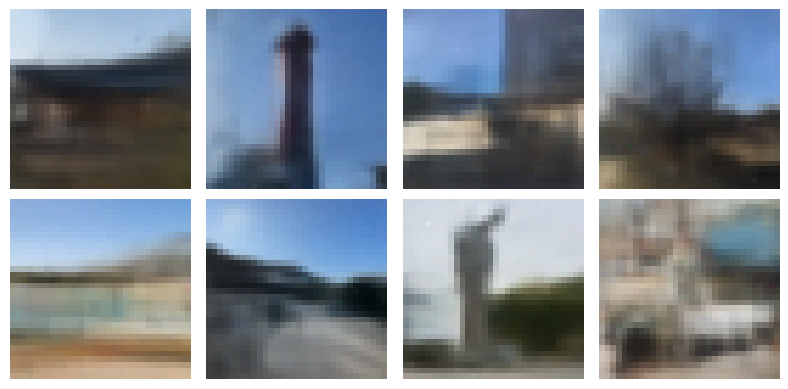

562/562 [==============================] - 86s 153ms/step - n_loss: 0.0126 - i_loss: 0.0251 - val_n_loss: 0.0123 - val_i_loss: 0.0197 - val_kid: 0.1142
Epoch 64/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0125 - i_loss: 0.0255

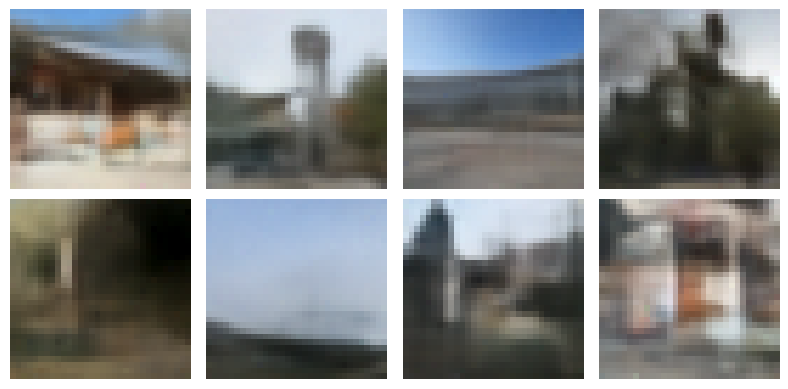

562/562 [==============================] - 86s 153ms/step - n_loss: 0.0125 - i_loss: 0.0255 - val_n_loss: 0.0121 - val_i_loss: 0.0198 - val_kid: 0.1161
Epoch 65/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0126 - i_loss: 0.0254

562/562 [==============================] - 86s 153ms/step - n_loss: 0.0126 - i_loss: 0.0254 - val_n_loss: 0.0123 - val_i_loss: 0.0198 - val_kid: 0.1174
Epoch 66/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0125 - i_loss: 0.0251

562/562 [==============================] - 86s 153ms/step - n_loss: 0.0125 - i_loss: 0.0251 - val_n_loss: 0.0123 - val_i_loss: 0.0197 - val_kid: 0.1151
Epoch 67/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0124 - i_loss: 0.0255

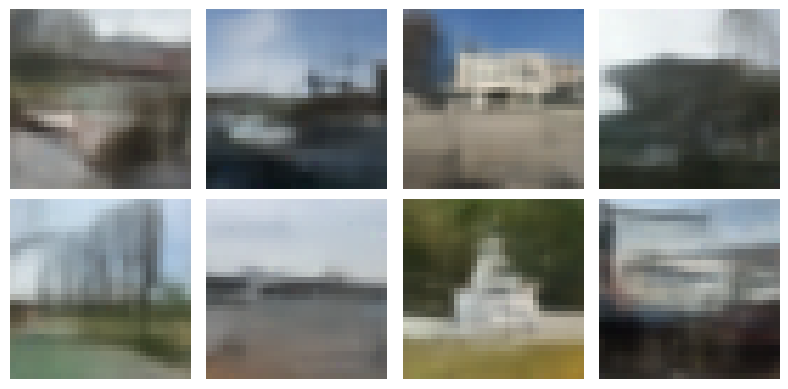

562/562 [==============================] - 86s 153ms/step - n_loss: 0.0124 - i_loss: 0.0255 - val_n_loss: 0.0123 - val_i_loss: 0.0199 - val_kid: 0.1164
Epoch 68/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0124 - i_loss: 0.0256

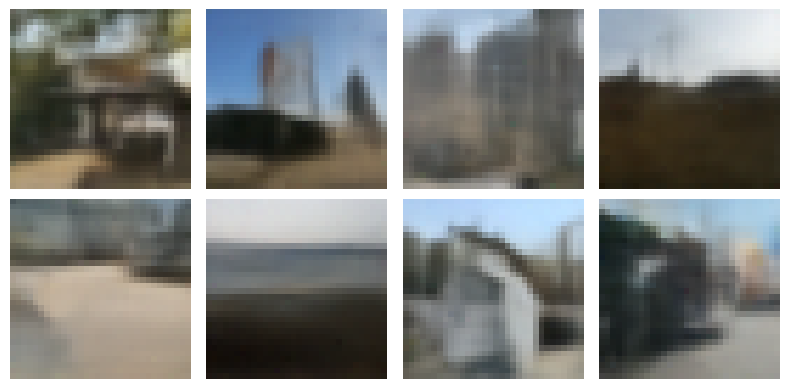

562/562 [==============================] - 87s 155ms/step - n_loss: 0.0124 - i_loss: 0.0256 - val_n_loss: 0.0123 - val_i_loss: 0.0197 - val_kid: 0.1136
Epoch 69/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0125 - i_loss: 0.0255

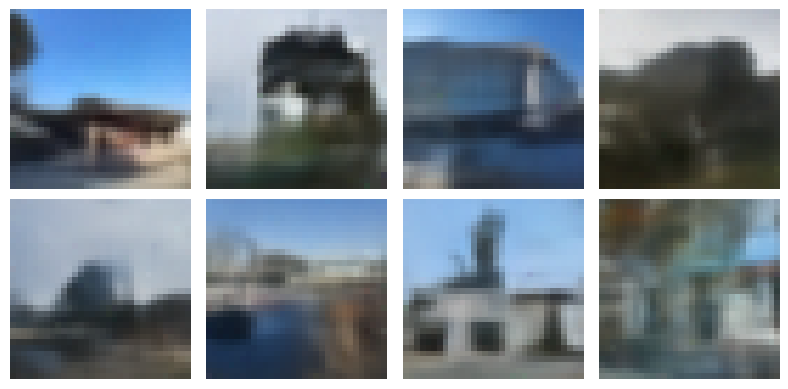

562/562 [==============================] - 87s 156ms/step - n_loss: 0.0125 - i_loss: 0.0255 - val_n_loss: 0.0123 - val_i_loss: 0.0197 - val_kid: 0.1114
Epoch 70/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0125 - i_loss: 0.0256

562/562 [==============================] - 86s 153ms/step - n_loss: 0.0125 - i_loss: 0.0256 - val_n_loss: 0.0124 - val_i_loss: 0.0196 - val_kid: 0.1127
Epoch 71/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0125 - i_loss: 0.0255

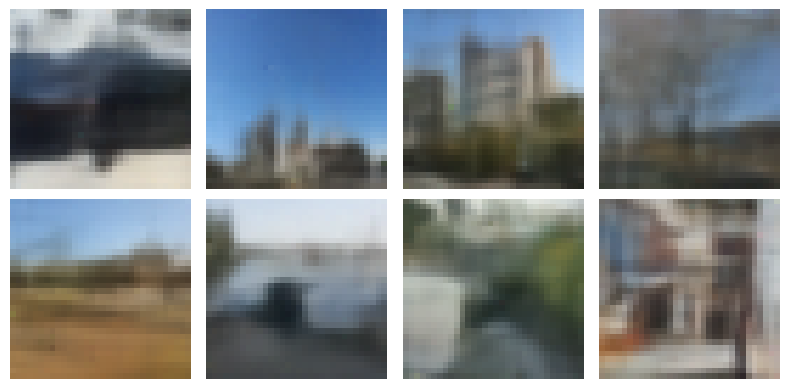

562/562 [==============================] - 86s 153ms/step - n_loss: 0.0125 - i_loss: 0.0255 - val_n_loss: 0.0122 - val_i_loss: 0.0197 - val_kid: 0.1127
Epoch 72/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0124 - i_loss: 0.0256

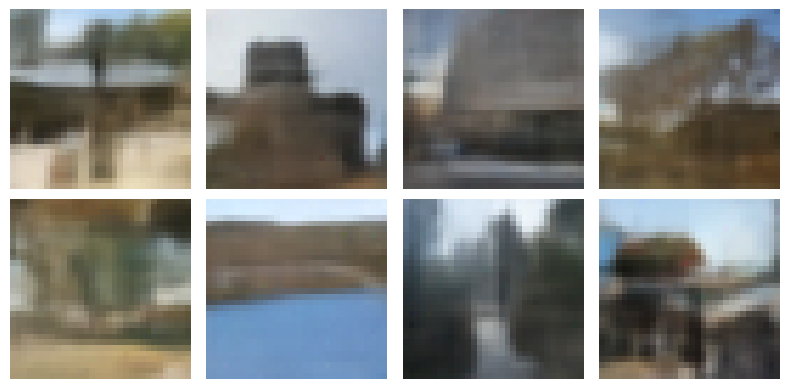

562/562 [==============================] - 86s 152ms/step - n_loss: 0.0124 - i_loss: 0.0256 - val_n_loss: 0.0121 - val_i_loss: 0.0197 - val_kid: 0.1149
Epoch 73/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0124 - i_loss: 0.0253

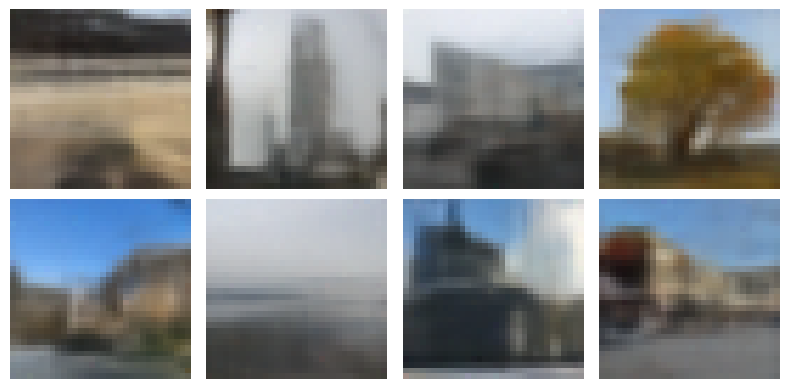

562/562 [==============================] - 86s 153ms/step - n_loss: 0.0124 - i_loss: 0.0253 - val_n_loss: 0.0121 - val_i_loss: 0.0198 - val_kid: 0.1126
Epoch 74/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0125 - i_loss: 0.0261

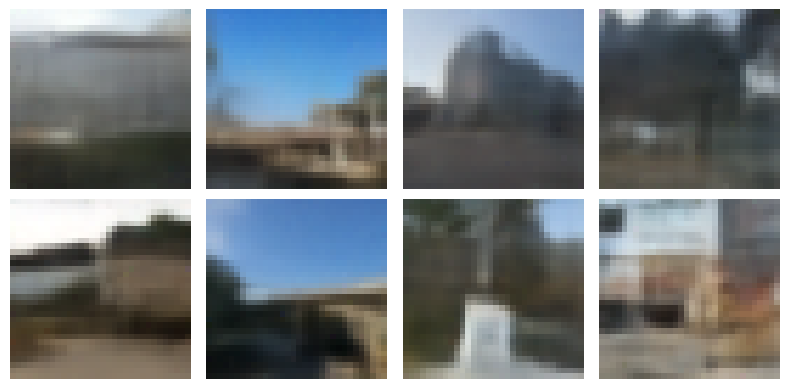

562/562 [==============================] - 86s 153ms/step - n_loss: 0.0125 - i_loss: 0.0261 - val_n_loss: 0.0122 - val_i_loss: 0.0197 - val_kid: 0.1122
Epoch 75/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0125 - i_loss: 0.0249

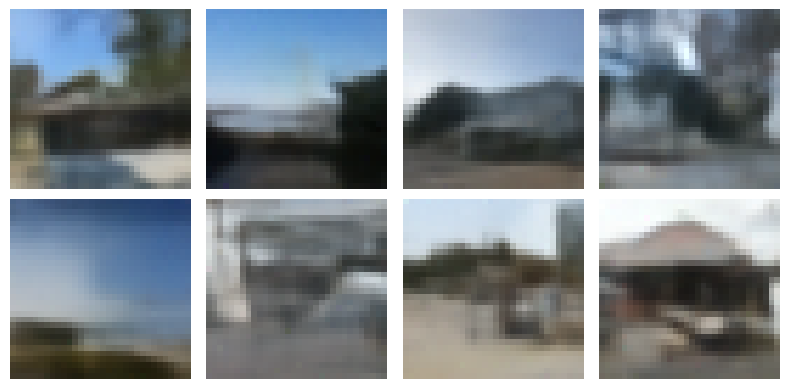

562/562 [==============================] - 86s 152ms/step - n_loss: 0.0125 - i_loss: 0.0249 - val_n_loss: 0.0123 - val_i_loss: 0.0196 - val_kid: 0.1138
Epoch 76/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0125 - i_loss: 0.0254

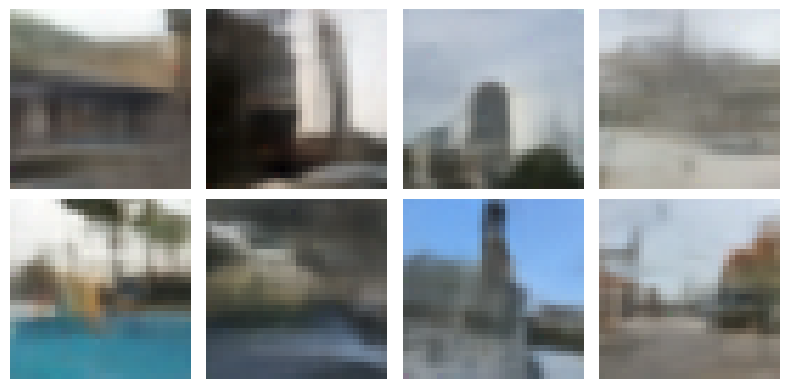

562/562 [==============================] - 87s 156ms/step - n_loss: 0.0125 - i_loss: 0.0254 - val_n_loss: 0.0120 - val_i_loss: 0.0197 - val_kid: 0.1102
Epoch 77/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0125 - i_loss: 0.0260

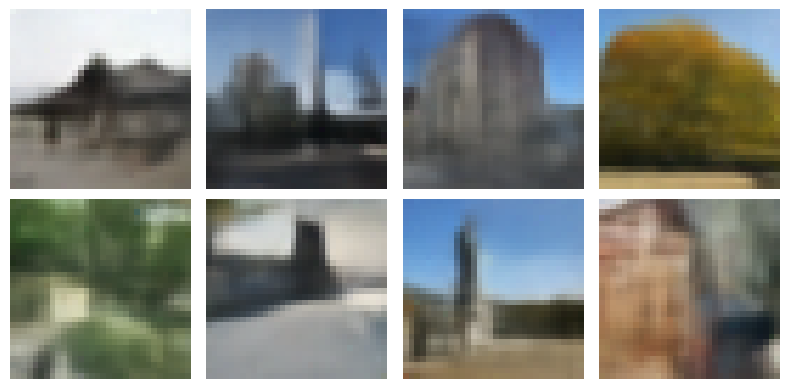

562/562 [==============================] - 86s 153ms/step - n_loss: 0.0125 - i_loss: 0.0260 - val_n_loss: 0.0123 - val_i_loss: 0.0196 - val_kid: 0.1115
Epoch 78/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0124 - i_loss: 0.0252

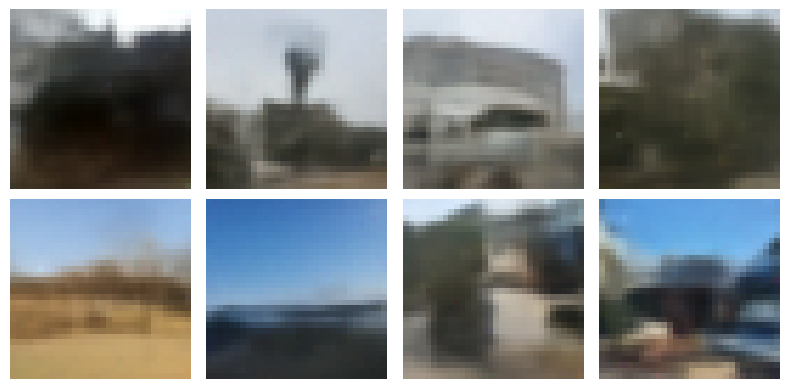

562/562 [==============================] - 86s 152ms/step - n_loss: 0.0124 - i_loss: 0.0252 - val_n_loss: 0.0121 - val_i_loss: 0.0199 - val_kid: 0.1107
Epoch 79/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0124 - i_loss: 0.0251

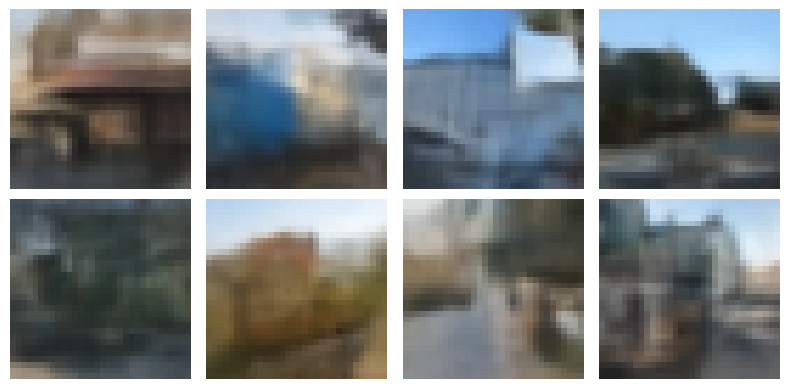

562/562 [==============================] - 86s 153ms/step - n_loss: 0.0124 - i_loss: 0.0251 - val_n_loss: 0.0120 - val_i_loss: 0.0197 - val_kid: 0.1110
Epoch 80/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0125 - i_loss: 0.0248

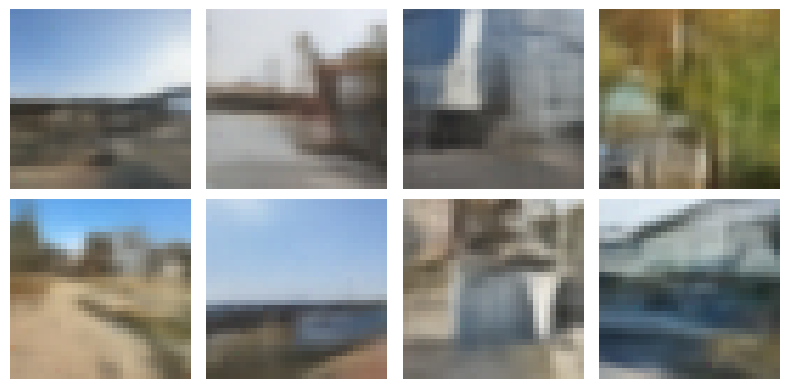

562/562 [==============================] - 86s 153ms/step - n_loss: 0.0125 - i_loss: 0.0248 - val_n_loss: 0.0124 - val_i_loss: 0.0195 - val_kid: 0.1123
Epoch 81/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0124 - i_loss: 0.0252

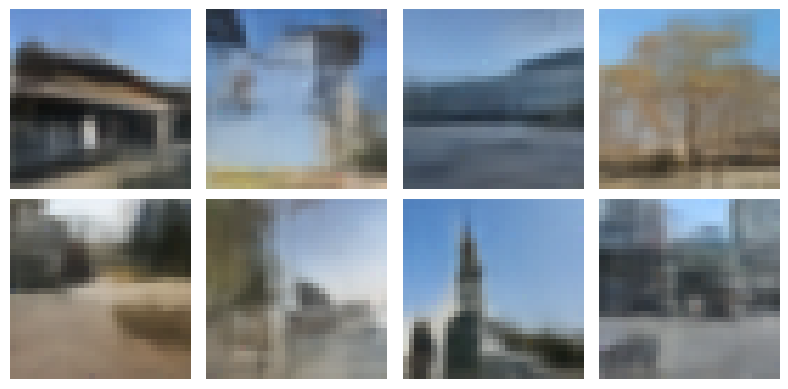

562/562 [==============================] - 86s 153ms/step - n_loss: 0.0124 - i_loss: 0.0252 - val_n_loss: 0.0123 - val_i_loss: 0.0197 - val_kid: 0.1108
Epoch 82/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0124 - i_loss: 0.0249

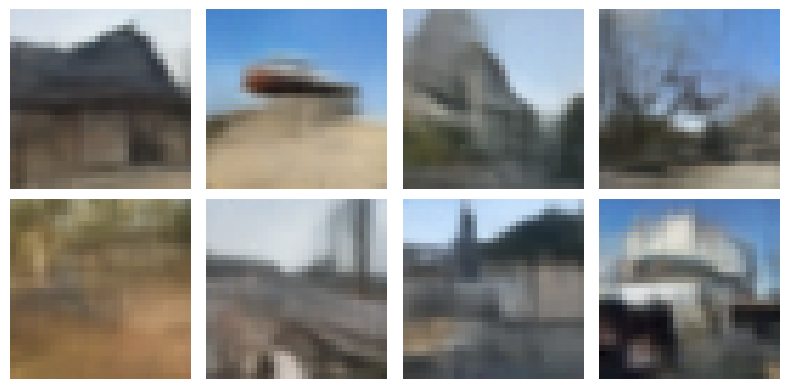

562/562 [==============================] - 86s 153ms/step - n_loss: 0.0124 - i_loss: 0.0249 - val_n_loss: 0.0122 - val_i_loss: 0.0197 - val_kid: 0.1103
Epoch 83/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0124 - i_loss: 0.0256

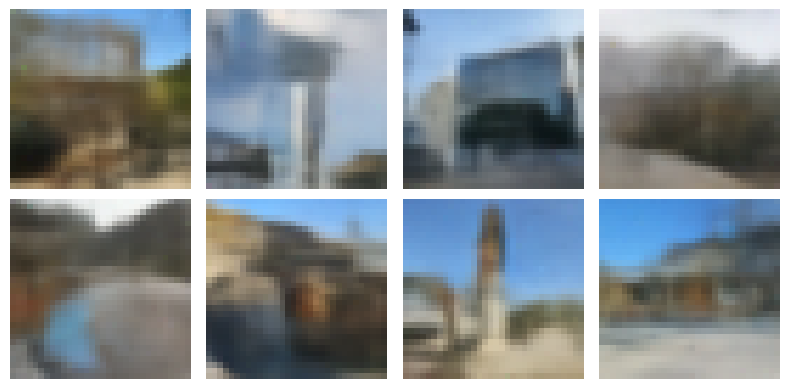

562/562 [==============================] - 86s 152ms/step - n_loss: 0.0124 - i_loss: 0.0256 - val_n_loss: 0.0122 - val_i_loss: 0.0198 - val_kid: 0.1124
Epoch 84/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0124 - i_loss: 0.0259

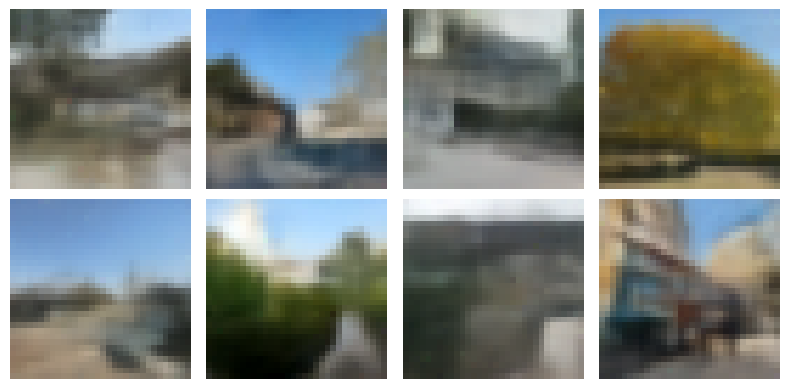

562/562 [==============================] - 86s 152ms/step - n_loss: 0.0124 - i_loss: 0.0259 - val_n_loss: 0.0122 - val_i_loss: 0.0194 - val_kid: 0.1113
Epoch 85/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0124 - i_loss: 0.0255

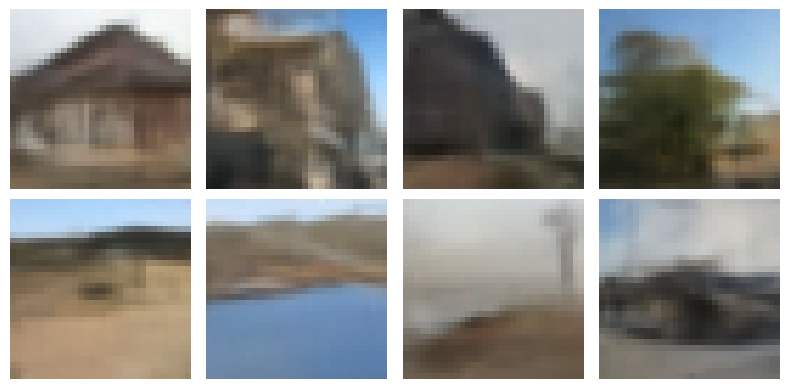

562/562 [==============================] - 86s 153ms/step - n_loss: 0.0124 - i_loss: 0.0255 - val_n_loss: 0.0123 - val_i_loss: 0.0197 - val_kid: 0.1112
Epoch 86/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0124 - i_loss: 0.0247

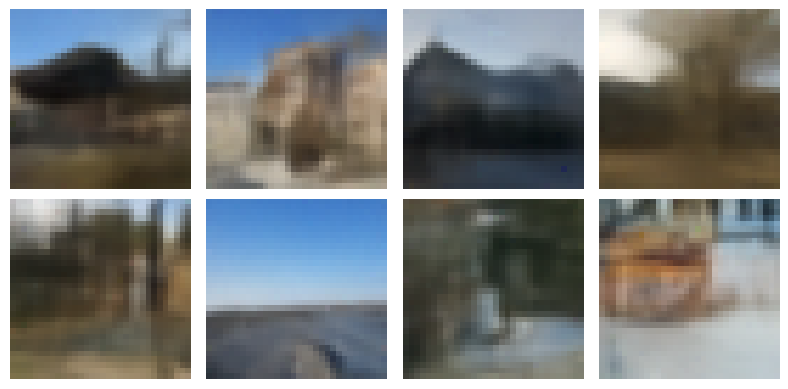

562/562 [==============================] - 86s 153ms/step - n_loss: 0.0124 - i_loss: 0.0247 - val_n_loss: 0.0122 - val_i_loss: 0.0197 - val_kid: 0.1102
Epoch 87/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0123 - i_loss: 0.0256

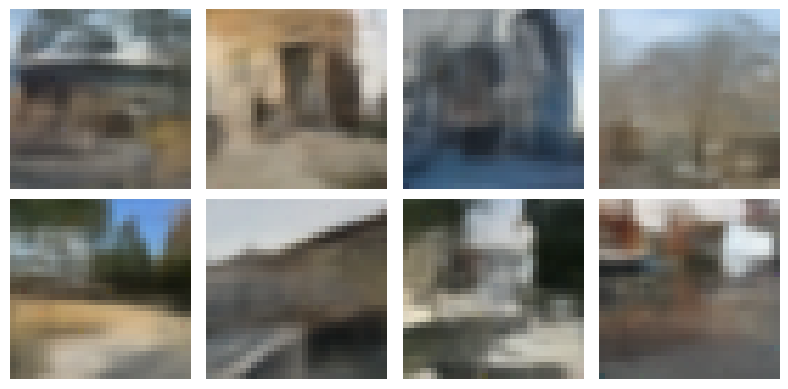

562/562 [==============================] - 86s 153ms/step - n_loss: 0.0123 - i_loss: 0.0256 - val_n_loss: 0.0122 - val_i_loss: 0.0198 - val_kid: 0.1114
Epoch 88/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0124 - i_loss: 0.0254

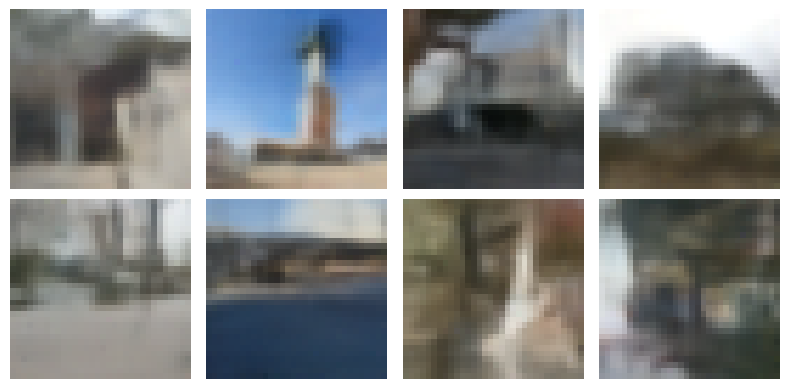

562/562 [==============================] - 87s 154ms/step - n_loss: 0.0124 - i_loss: 0.0254 - val_n_loss: 0.0121 - val_i_loss: 0.0197 - val_kid: 0.1098
Epoch 89/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0123 - i_loss: 0.0250

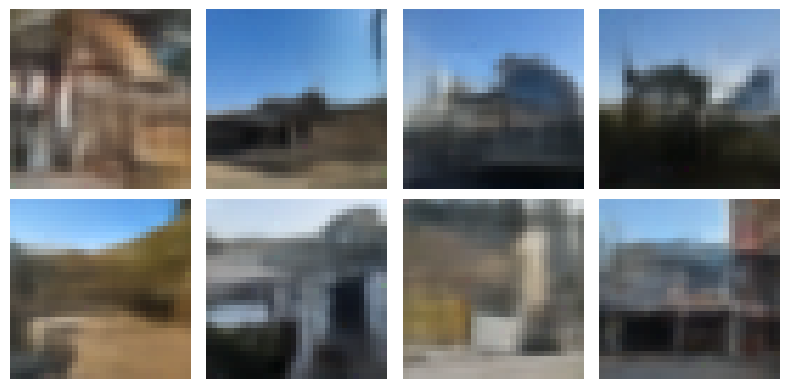

562/562 [==============================] - 86s 152ms/step - n_loss: 0.0123 - i_loss: 0.0250 - val_n_loss: 0.0123 - val_i_loss: 0.0196 - val_kid: 0.1115
Epoch 90/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0124 - i_loss: 0.0261

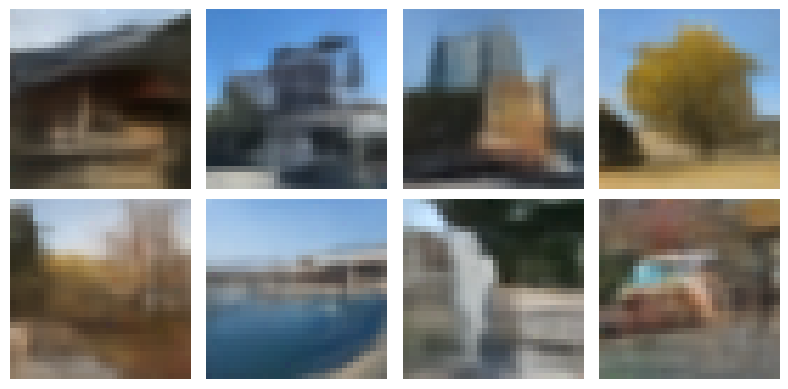

562/562 [==============================] - 86s 153ms/step - n_loss: 0.0124 - i_loss: 0.0261 - val_n_loss: 0.0122 - val_i_loss: 0.0197 - val_kid: 0.1118
Epoch 91/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0124 - i_loss: 0.0258

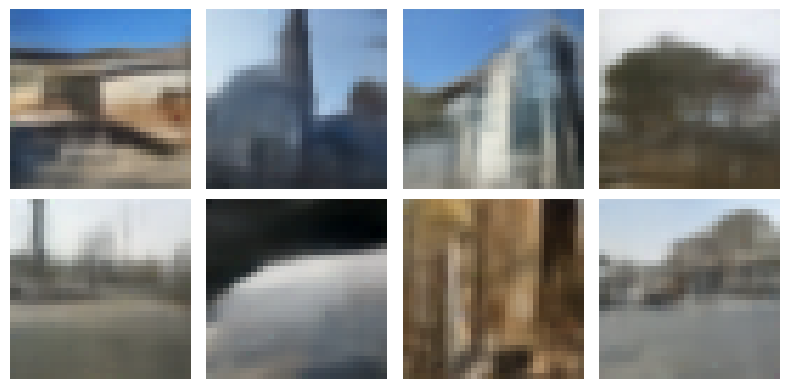

562/562 [==============================] - 86s 153ms/step - n_loss: 0.0124 - i_loss: 0.0258 - val_n_loss: 0.0122 - val_i_loss: 0.0195 - val_kid: 0.1110
Epoch 92/100
562/562 [==============================] - ETA: 0s - n_loss: 0.0124 - i_loss: 0.0254

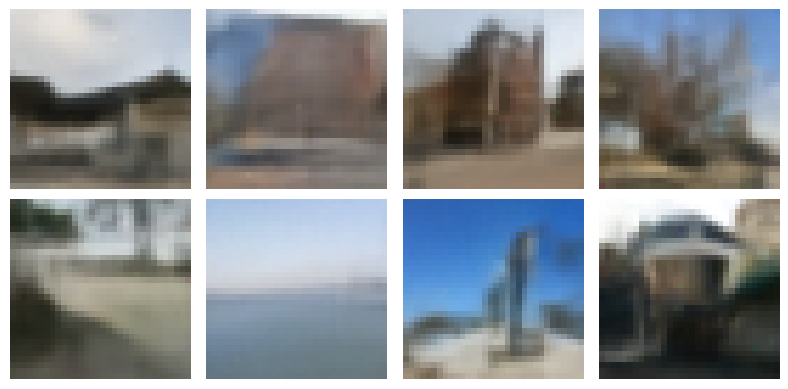

562/562 [==============================] - 87s 155ms/step - n_loss: 0.0124 - i_loss: 0.0254 - val_n_loss: 0.0123 - val_i_loss: 0.0193 - val_kid: 0.1087
Epoch 93/100
421/562 [=====================>........] - ETA: 18s - n_loss: 0.0123 - i_loss: 0.0259

In [ ]:
# run training and plot generated images periodically
model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[
        keras.callbacks.LambdaCallback(on_epoch_end = model.plot_images),
        checkpoint_callback,
    ],
)

## 인퍼런스

### 전체 Class 출력

In [ ]:
# load the best model and generate images
model.load_weights(checkpoint_path)
model.plot_images()

### 입력 클래스 출력

In [ ]:
# 출력하고 싶은 class 번호 입력
input_value = 5
print('class :', class_name[input_value])
model.plot_one_images(input_class = input_value)

In [ ]:
for i in range(8):
    print(class_name_kor[i])
    model.plot_one_images(input_class = i)